# **Финальный проект 1 года обучения на курсе DSPR-2.0 от Skillfactory** #


## **Построение прогноза количества госпитализирированных в психиатрическую больницу через приемное отделение** ##

**Бизнес задача:** Построить прогноз поступления пациентов через приемное отделение психиатрической больнице  
        
**Технические задачи:**
1. Проанализировать сырые данные, состваить из них временной ряд
2. Провести перивичный анализ временного ряда
3. Построить базовую модель
4. Произвести посик модели дающей лучшие предсказания на тренировочной и валидационных выборках
5. Произвести окончательную проверку качества моделей на тренировочной выборке
6. Произвести выгрузку обученной модели в файл, для последующего использования в продакшене

## Загрузка данных и первичная обработка

In [1]:
# Выполняем загрузку необходимых модулей
import pandas as pd
import numpy as np
import sklearn.preprocessing
import sklearn.metrics
import sklearn.ensemble
import sklearn.linear_model
import sklearn.feature_selection
import sklearn.model_selection
import sklearn.tree
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.arima.model
import matplotlib.pyplot as plt
import seaborn as sns
import re
import datetime
from datetime import timedelta
from statsmodels.tsa.statespace.sarimax import SARIMAX

# избавляемся от назойливых warning`ов
import warnings
warnings.filterwarnings('ignore')

Произведём загрузку данных

In [2]:
data = pd.read_csv('./data.csv', sep=';')

Проверим что получилось

In [3]:
data.head()

,DPOST
0,01.01.2013
1,02.01.2013
2,02.01.2013
3,02.01.2013
4,03.01.2013


Данные загрузились нормально.  
Поскольку данные были предоставленны в максимально деперсонализированном формате, то у нас имеются записи только с датой поступления, каждая запись отображает одного поступившего.
Для дальнейшего анализа, сформируем временной ряд, для этого сгруппируем данные по дате поступление и посчитаем количество поступивших за каждый день.

In [4]:
# Преобразуем столбец с датой в фориат pandas datetime
data.DPOST = pd.to_datetime(data.DPOST, format='%d.%m.%Y')

In [5]:
# Посмотрим на общее описание столбца
data.describe()

,DPOST
count,36170
unique,3632
top,2019-04-16 00:00:00
freq,33
first,2013-01-01 00:00:00
last,2022-12-31 00:00:00


Видно, что количество записей соответствует 36170 поступивших,  
День в который наблюдалось максимальное поступление это - 16 апреля 2019 года - 33 пациента  
Теперь посмотрим, на максимальную и минимальную даты - на случай возможных аномалий
Первая дата 01.01.2023, а последняя 31.12.2022 - выбросов в данных не обнаружено.  
Приступим к группировке данных по дням для формирования временного ряда

In [6]:
# Добавим признак количества поступивших по которому считать количество записей за день
data['count'] = 1
# Проведем группировку данных
df = data.groupby(by='DPOST').sum()

In [7]:
# Приведем частоту временного ряда к дневной
df = df.asfreq(freq='D')

In [8]:
# Проверим наличие пропусков
df.isna().sum()

count    20
dtype: int64

Как видно, имеются 20 пропусков. Эти пропуски заполним 0, т.к. они образовались из-за того, что за эти дни не было ни одной записи, что получилось, т.к. в эти дни никто не поступал.

In [9]:
df = df.fillna(0)
df.isna().sum()

count    0
dtype: int64

## Анализ временного ряда

Теперь визуализируем то, что получилось

<Axes: xlabel='DPOST', ylabel='count'>

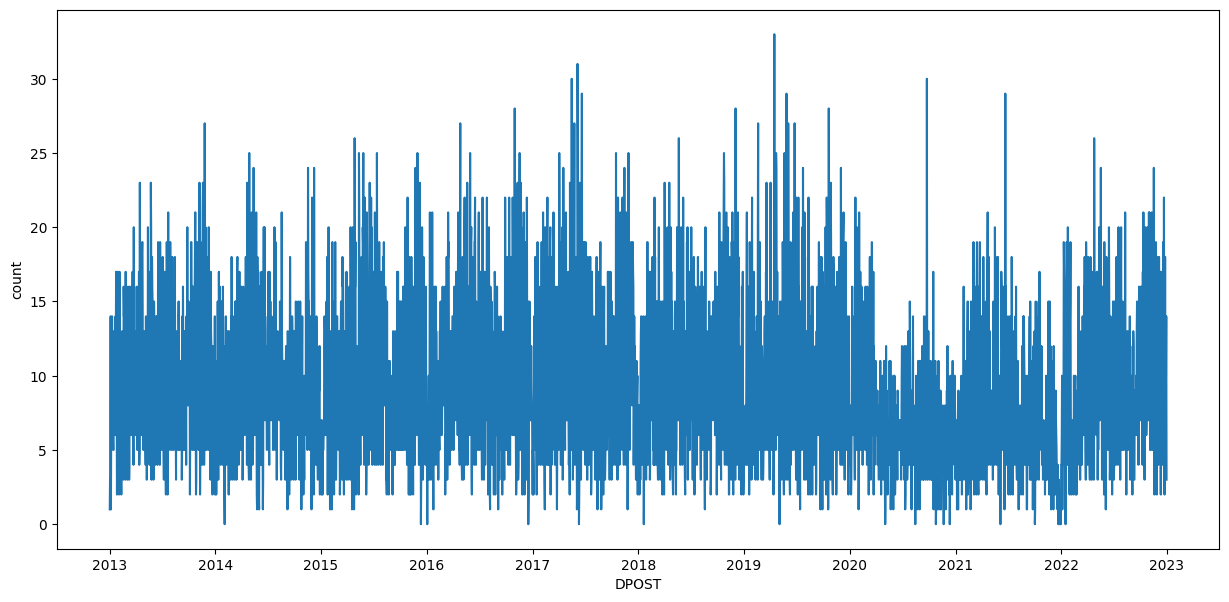

In [10]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.lineplot(df['count'], ax=ax)

В ряде угадывается наличие сезонности, отчетливого тренда не видно. Также сразу бросаются в глаза данные за 2020-2021 года - это последствие пандемии COVID-19, когда из-за карантинных ограничений были сокращены плановые госпитализаии да и сами люди предпочитали избегать людных мест. <br/>
Теперь разложм ряд на стоставляющие и посмотрим на них

Text(0.5, 1.0, 'Компонент остатков')

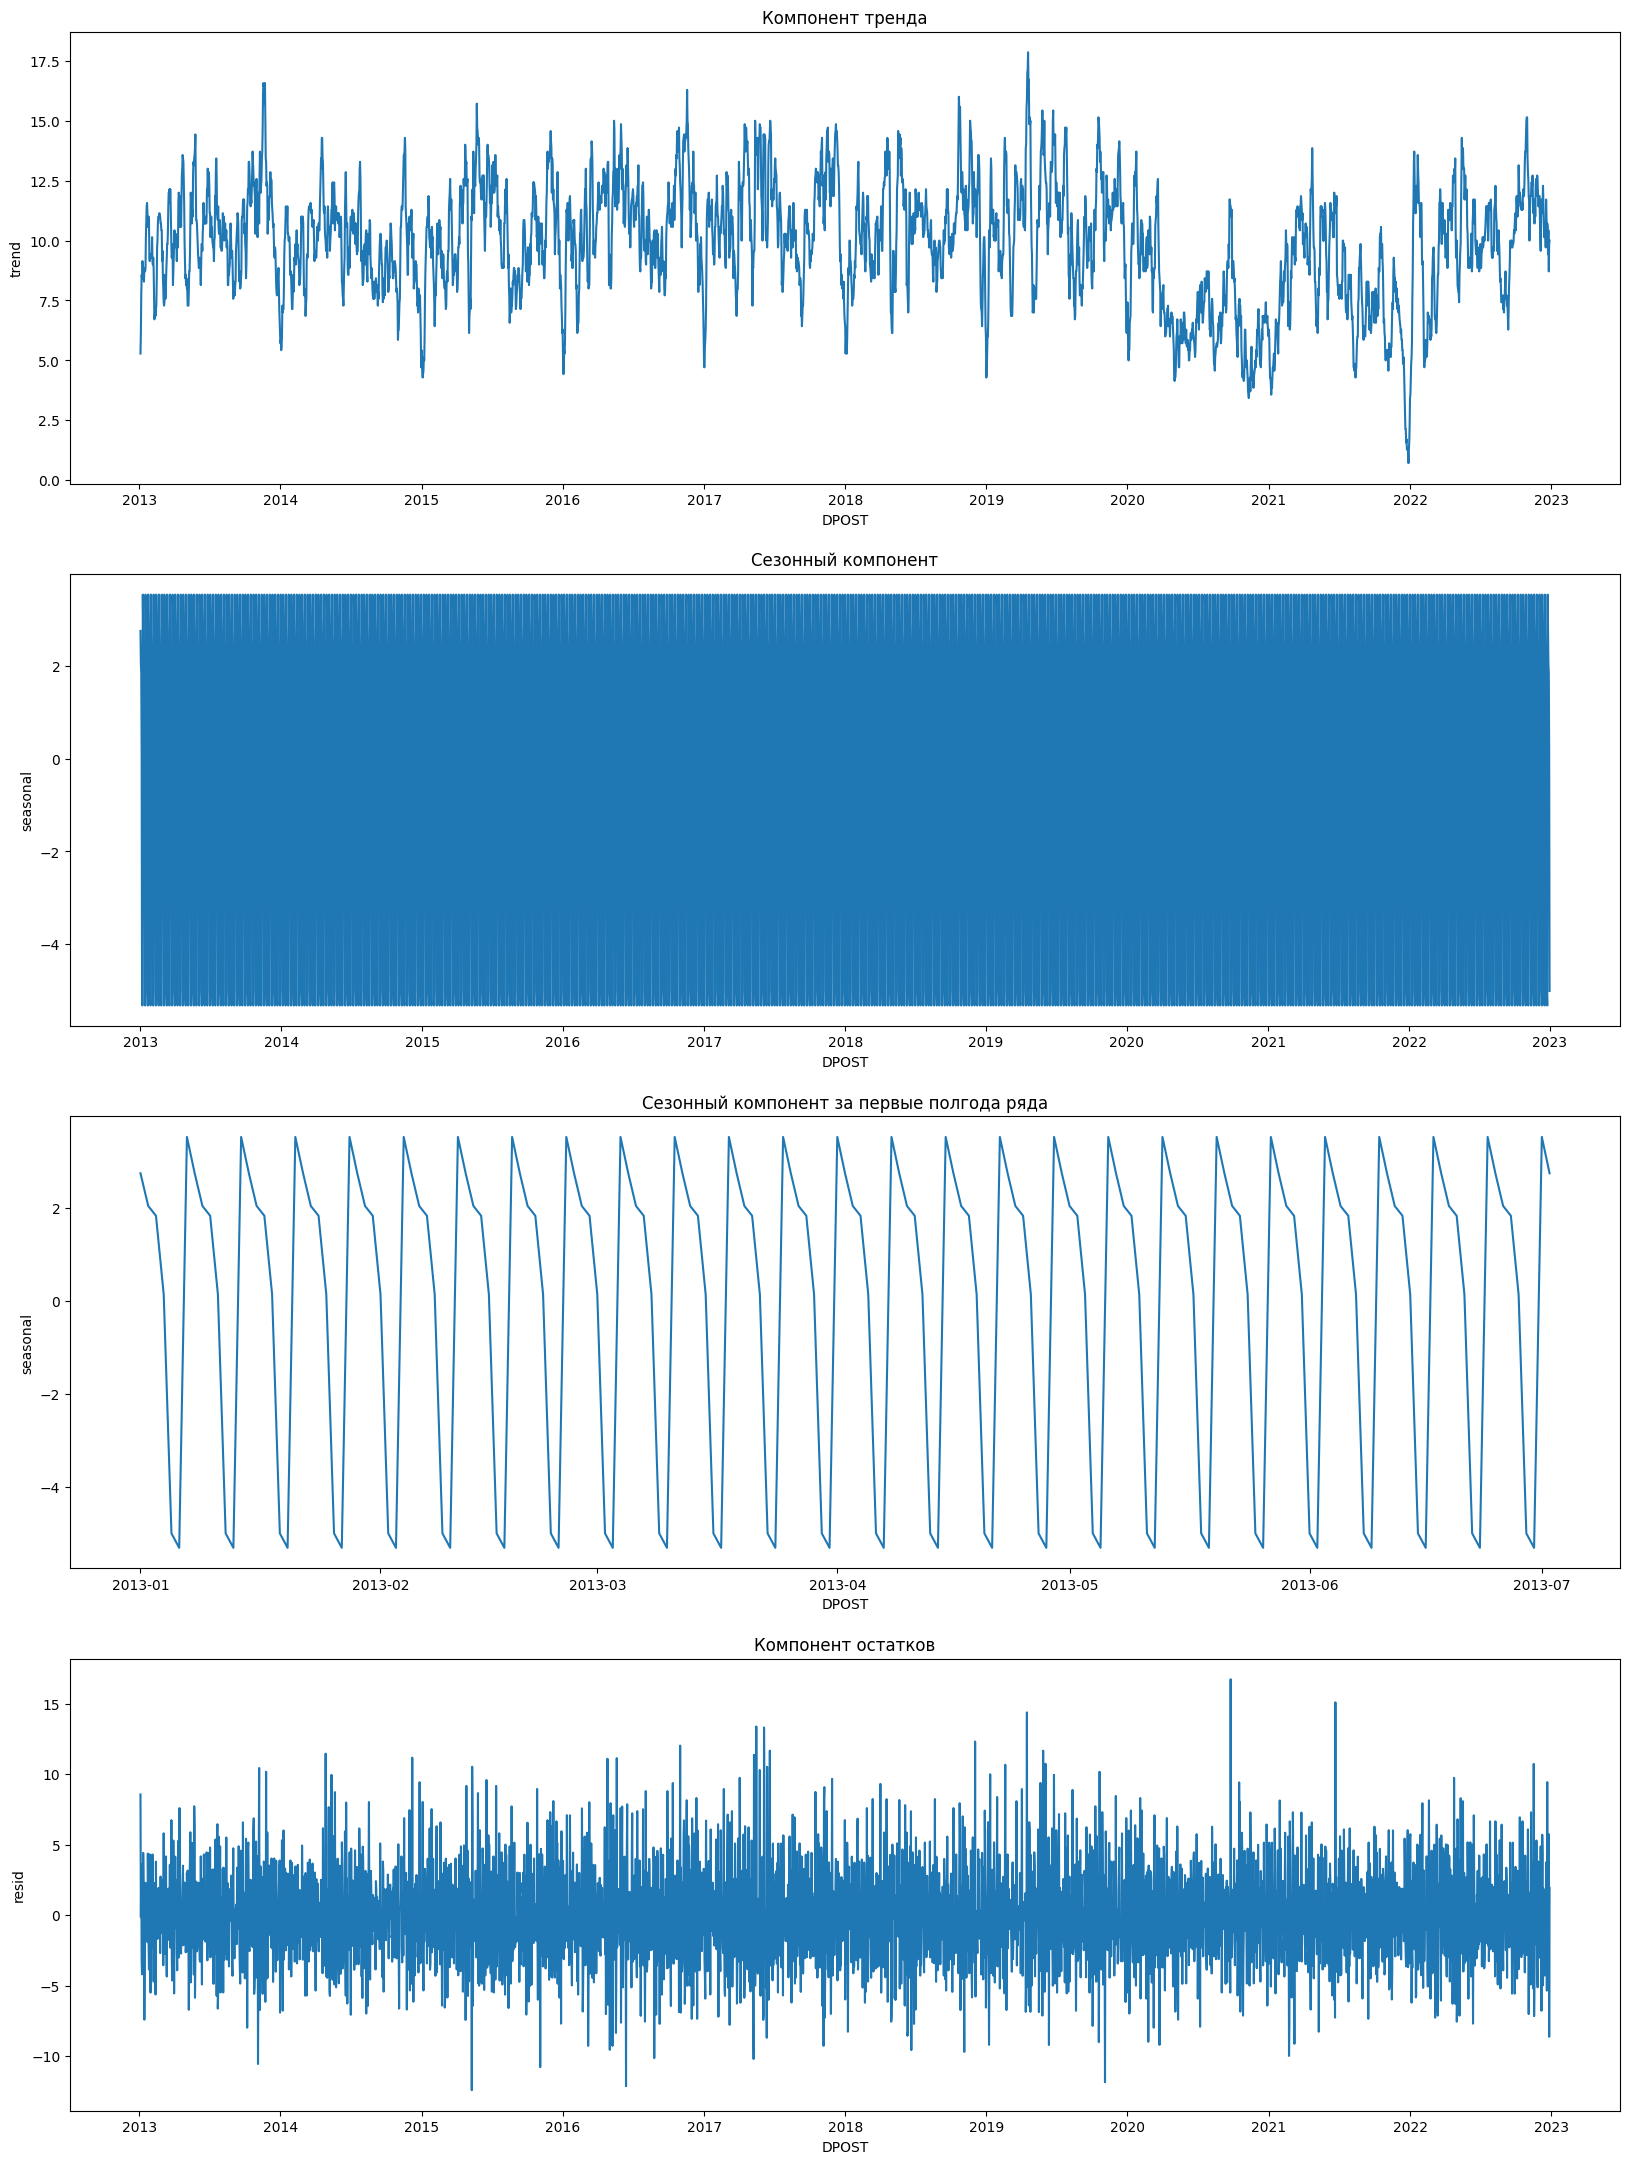

In [11]:
fig, ax = plt.subplots(4, 1, figsize=(20, 27))
result = seasonal_decompose(df['count'].dropna())
sns.lineplot(result.trend, ax=ax[0])
ax[0].set_title('Компонент тренда')
sns.lineplot(result.seasonal, ax=ax[1])
ax[1].set_title('Сезонный компонент')
# Увеличим масштаб для отображения сезонного компонента
sns.lineplot(result.seasonal[:183], ax=ax[2])
ax[2].set_title('Сезонный компонент за первые полгода ряда')
sns.lineplot(result.resid, ax=ax[3])
ax[3].set_title('Компонент остатков')

При разложении ряда в компоненте тренда видна годовая сезонность, приотсутствии общего тренда. В сезонной компоненте отчетливо видна недельная сезонность. При этом в компоненте остатков также имеется некоторая неоднородность, но без бросающейся в глаза цикличности, причем компонент остатков имеет самый высокий разброс среди компонентов.
<br/>
Теперь проверим ряд на стационарность

In [12]:
# Создадим функцию для удобства повторного использования
def test_adfuller(data):
    test = adfuller(data)
    print('adf: ', test[0])
    print('p-value: ', test[1])
    print('Critical values: ', test[4])
    condition = test[0] > test[4]['5%']
    if condition:
        print('Nonstationary')
    else:
        print('Stationary')

In [13]:
test_adfuller(df['count'].dropna())

adf:  -5.983806582580192
p-value:  1.8121176252569573e-07
Critical values:  {'1%': -3.43215622115055, '5%': -2.862338087688428, '10%': -2.5671948344809046}
Stationary


Итак, ряд стационарен. Отобразим для него графики автокорреляции и частичной автокорреляции

In [14]:
import statsmodels.graphics.tsaplots as sgt

# Для удобства использования для отображения графиков создадим функцию


def plot_acf_pacf(series):

    fig, axes = plt.subplots(1, 2, figsize=(18, 10))

    sgt.plot_acf(series, ax=axes[0])
    sgt.plot_pacf(series, ax=axes[1])
    plt.show()

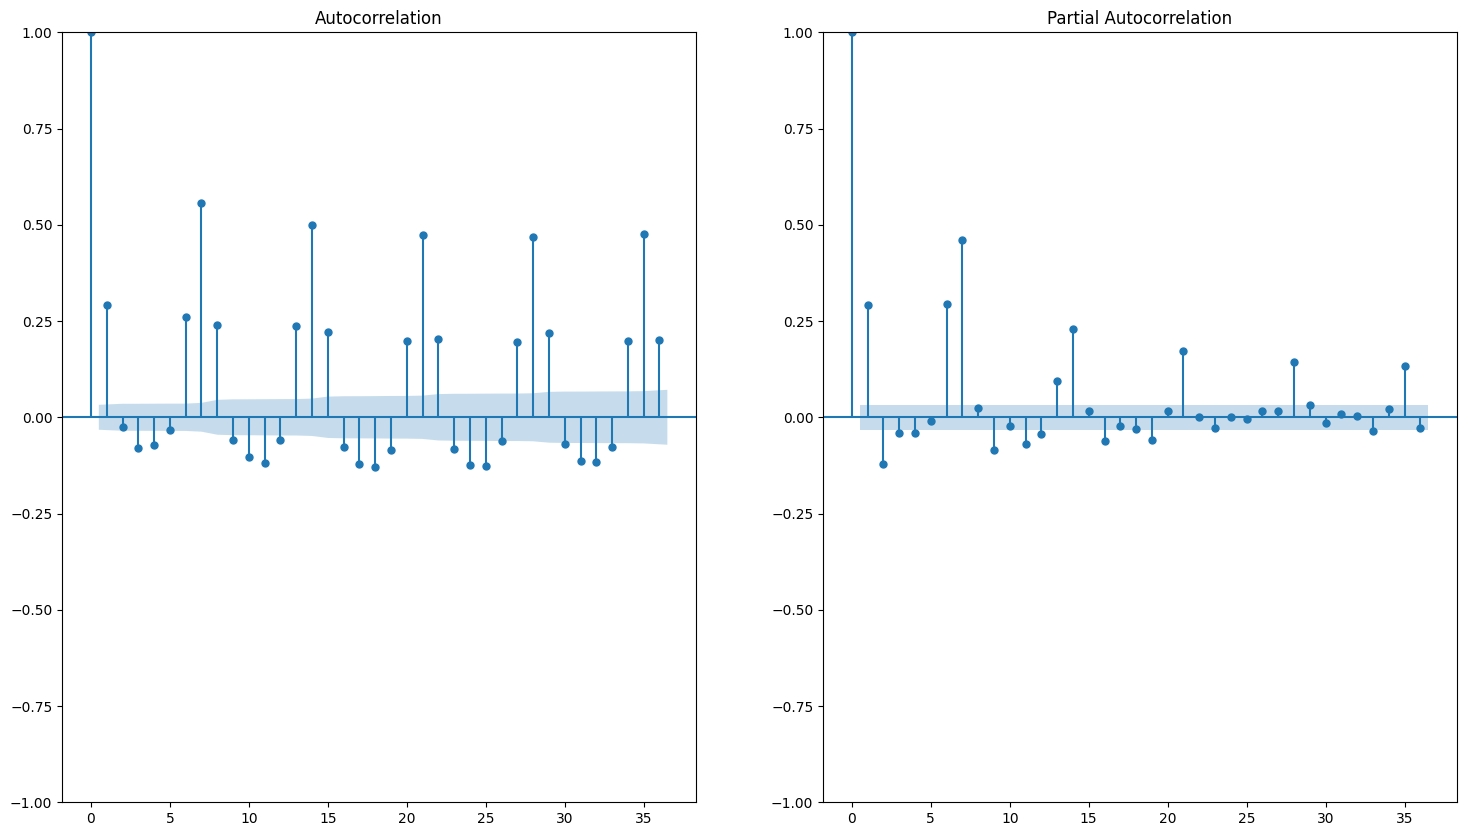

In [15]:
plot_acf_pacf(df['count'])

На графиках видна отчетливая недельная сезонность - лаги кратные 7.
<br/>
## Построение baseline
<br/>
Теперь приступим к посторению baseline. Для этого сделаем прогноз несколькими простыми методами - простым средним, наивным прогнозом - последнее наблюдаемое значение. И наконец сезонным наивным прогнозом, и так как у нас недельная сезонность, то для посторения будем брать значение за тот же день недели на предыдущей неделе.
<br/>
В качестве тестовой возьмем выборку за последние полгода

In [16]:
train_df = df.iloc[:-183]
test_df = df.iloc[-183:]

In [17]:
# Прогноз простым средним
test_df['mean'] = train_df['count'].mean()
# Наивный прогноз
test_df['naive'] = train_df['count'].iloc[-1]
# Наивный сезонный прогноз
train_df['day'] = train_df.index.day_of_week
test_df['day'] = test_df.index.day_of_week

ses_naive = []
for row_idx, row in test_df.iterrows():
    day = row['day']
    forecast = train_df['count'].loc[train_df['day'] == day].iloc[-1]
    ses_naive.append(forecast)
test_df['ses_naive'] = ses_naive

Text(0.5, 1.0, 'Seaseonal Naive Forecasting')

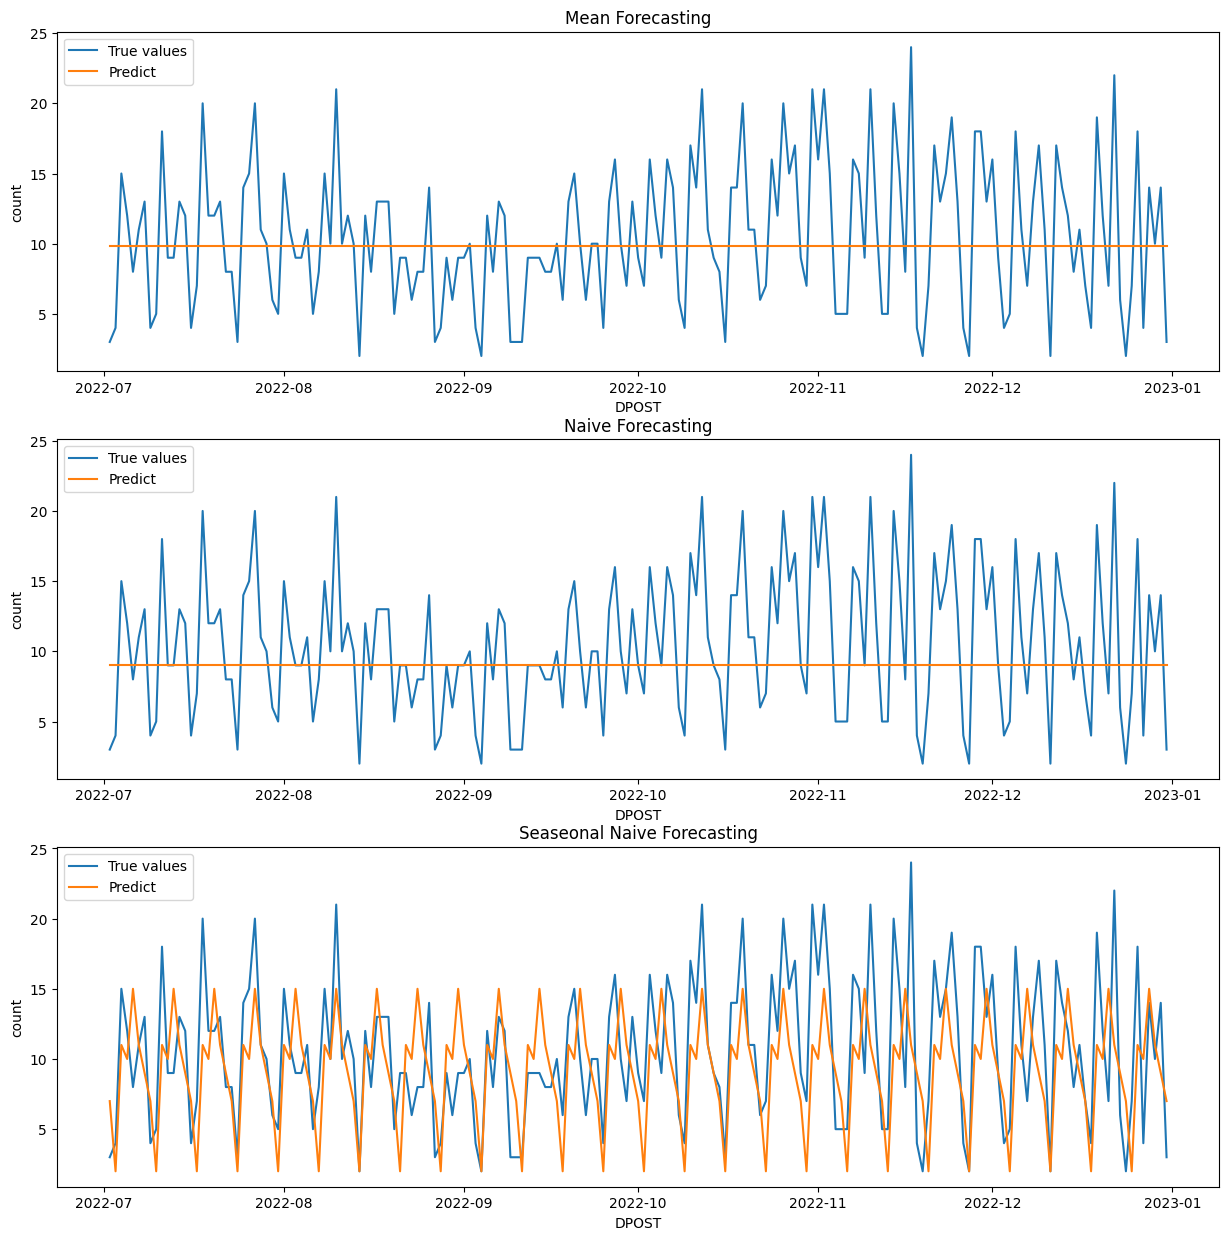

In [18]:
# Построим графики прогнозов
fig, ax = plt.subplots(3, 1, figsize=(15, 15))
sns.lineplot(test_df['count'], ax=ax[0], label='True values')
sns.lineplot(test_df['mean'], ax=ax[0], label='Predict')
ax[0].set_title('Mean Forecasting')
sns.lineplot(test_df['count'], ax=ax[1], label='True values')
sns.lineplot(test_df['naive'], ax=ax[1], label='Predict')
ax[1].set_title('Naive Forecasting')
sns.lineplot(test_df['count'], ax=ax[2], label='True values')
sns.lineplot(test_df['ses_naive'], ax=ax[2], label='Predict')
ax[2].set_title('Seaseonal Naive Forecasting')

По графикам видно, что наилучший результат у сезонного наивного прогноза. Теерь посмотрим в цифрах. Для оценки будем использовать среднюю абсолютную ошибку, а для наглядности взвешенную абсолютную процентную ошибку (среднюю процентную ошибку в данном случае использовать не получится, т.к. в данных очень много значений близких к нулю, что будет значительно завышать ошибку в нижних точках графика)

In [19]:
# Создадим функцию для подсчета WAPE
def wape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / y_true.sum()
# Функция для отображения результатов подсчета MAE и MAPE


def print_metrics(y_true, y_pred, label=''):
    if label != '':
        print(f'Metrics for {label}')
    print(
        f'MAE: {np.round(sklearn.metrics.mean_absolute_error(y_true, y_pred), 3)}')
    print(f'WAPE: {np.round(wape(y_true, y_pred), 3)}')


print_metrics(test_df['count'], test_df['mean'], 'Mean forecasting')
print_metrics(test_df['count'], test_df['naive'], 'Naive forecasting')
print_metrics(test_df['count'], test_df['ses_naive'],
              'Seaseonal naive forecasting')

Metrics for Mean forecasting
MAE: 4.173
WAPE: 0.396
Metrics for Naive forecasting
MAE: 4.235
WAPE: 0.402
Metrics for Seaseonal naive forecasting
MAE: 3.645
WAPE: 0.346


Итак, цифры также показали, что наилучшей из базовых моделей является сезонное наивное предсказание, значение его метрики и возьмем в качестве Baseline.
<br/>
## Первые модели
<br/>
Следующей моделью возьмем экспоненциальное сглаживание.

In [20]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
train_df = df.iloc[:-183]
test_df = df.iloc[-183:]

# Создадим модель
model = ExponentialSmoothing(
    train_df['count'], trend='add', seasonal='add', seasonal_periods=7)
# Обучим ее
model_fit = model.fit()

start = test_df.index[0]
end = test_df.index[-1]

# Сделаем предсказание
exp_forecast = model_fit.predict(start, end)

# Сохраним предсказание в тестовый датаврейм для удобства отображения
test_df = pd.merge(test_df, pd.DataFrame(exp_forecast), how='left',
                   left_index=True, right_index=True).rename(columns={0: 'preds'})

In [21]:
# Для удобства последующие визуализации прогнозов моделей и отображения метрик качества создадим функцию
def show_results(pred, test, with_cols=False, test_col='count', pred_col='model_preds', title=''):
    # Визуализируем данные
    fig, ax = plt.subplots(figsize=(15, 8))
    if with_cols:
        pred = pred[pred_col]
        test = test[test_col]
    sns.lineplot(test, color="blue", label="Actuals")
    sns.lineplot(pred, color="red", label="Forecast")
    if title != '':
        ax.set_title(f'{title} model predict')

    print_metrics(test, pred.loc[test.index], title)

Metrics for ExponentialSmoothing
MAE: 2.995
WAPE: 0.284


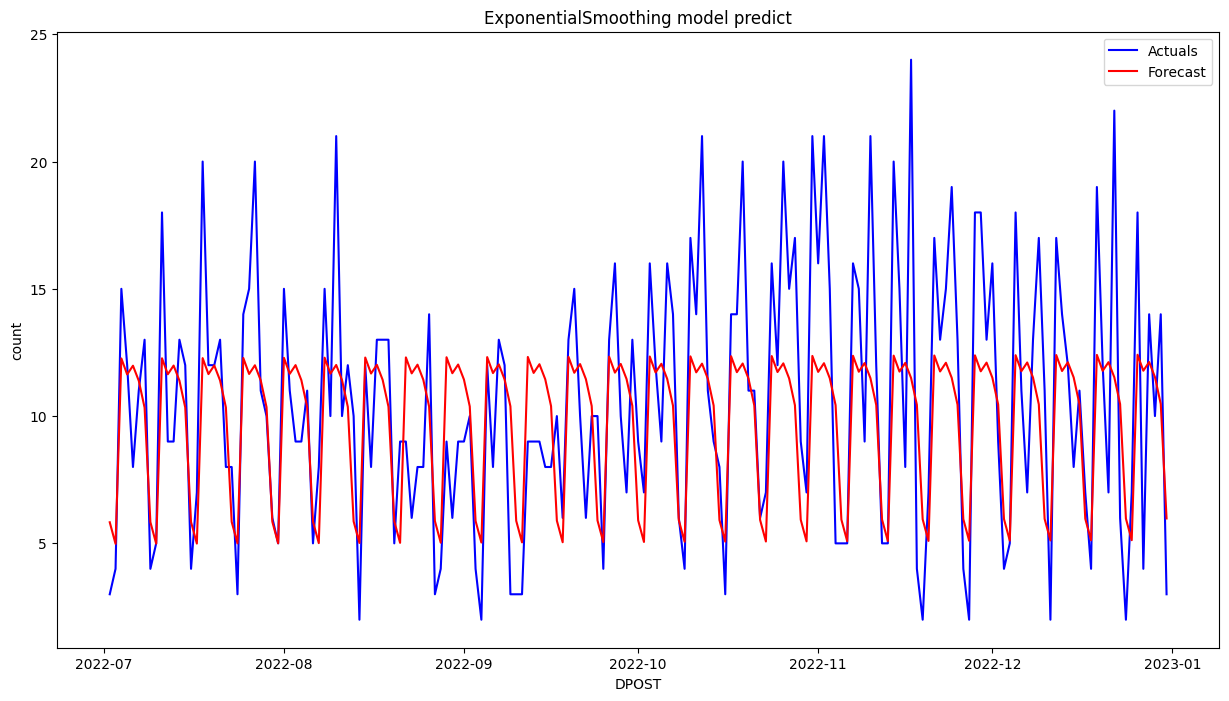

In [22]:
show_results(test_df.dropna()['preds'], test_df.dropna()['count'],
             title='ExponentialSmoothing')

Модель экспоненциального сглаживания показала значительное улучшение прогноза по сравнение с baseline - MAE на 0.65 и WAPE на 0.06.

<br/>
<br/>
Теперь попробуем обучить более сложную модель авторегрессивногоинтегрированного скользящего среднего

In [23]:
# Обновим тестовую выборку
test_df = df.dropna().iloc[-183:]

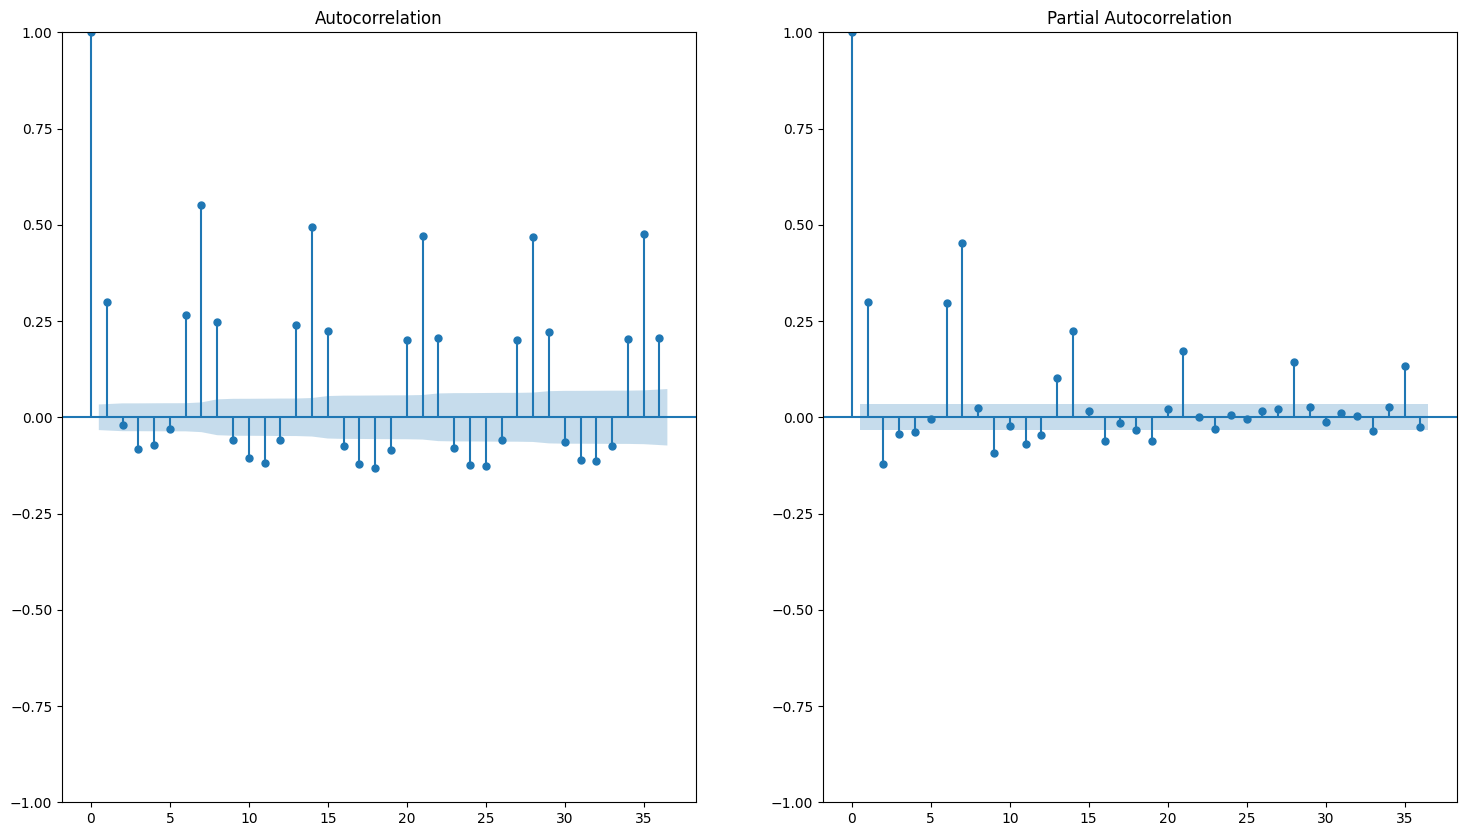

In [24]:
# Вновь визуализируем графики авокрреляции и частичной автокорреляции для подбора значений ARIMA
plot_acf_pacf(train_df['count'].dropna())

Итак, на графиках видно, что последними идущими подряд значимым корреляциями являются лаги 2 для pacf и 1 для acf. Однако также видны и значимые корреляции более поздних лагов вплоть до 6го. Также отчетливо визуализируется сезонный компонент - лаги кратные 7.
В качестве инструмента для подбора параметров модели будем использовать auto_arima из пакета pmdarima. В качестве начальных значений зададим 6, 0, 6 и 6, 0, 6, 7

In [25]:
#!pip install pmdarima
from pmdarima import auto_arima

In [ ]:
a_arima = auto_arima(y=train_df['count'], max_p=6, max_q=6, d=0, max_P=6, max_Q=6, start_p=6,
                     start_q=6, start_P=1, start_Q=1, m=7, max_order=30, seasonal=True, trace=True)
a_arima.summary()

Performing stepwise search to minimize aic
 ARIMA(6,0,6)(1,0,1)[7] intercept   : AIC=19468.448, Time=43.93 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=21619.912, Time=0.08 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=20267.319, Time=1.68 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=20660.030, Time=1.22 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=26656.470, Time=0.05 sec
 ARIMA(6,0,6)(0,0,1)[7] intercept   : AIC=inf, Time=23.44 sec
 ARIMA(6,0,6)(1,0,0)[7] intercept   : AIC=inf, Time=23.24 sec
 ARIMA(6,0,6)(2,0,1)[7] intercept   : AIC=19456.581, Time=39.18 sec
 ARIMA(6,0,6)(2,0,0)[7] intercept   : AIC=19975.597, Time=35.59 sec
 ARIMA(6,0,6)(3,0,1)[7] intercept   : AIC=19482.513, Time=79.40 sec
 ARIMA(6,0,6)(2,0,2)[7] intercept   : AIC=19454.591, Time=50.75 sec
 ARIMA(6,0,6)(1,0,2)[7] intercept   : AIC=19438.174, Time=44.88 sec
 ARIMA(6,0,6)(0,0,2)[7] intercept   : AIC=inf, Time=42.74 sec
 ARIMA(6,0,6)(1,0,3)[7] intercept   : AIC=19427.154, Time=66.98 sec
 ARIMA(6,0,6)(0,0,3)[7] int

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                         
=================================================================================================
Dep. Variable:                                         y   No. Observations:                 3469
Model:             SARIMAX(6, 0, 6)x(1, 0, [1, 2, 3], 7)   Log Likelihood               -9695.577
Date:                                   Mon, 17 Apr 2023   AIC                          19427.154
Time:                                           03:20:11   BIC                          19537.883
Sample:                                       01-01-2013   HQIC                         19466.690
                                            - 07-01-2022                                         
Covariance Type:                                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.2381      0.431      2.869      0.004       0.392       2.084
ar.L1         -3.1312      0.085    -36.895      0.000      -3.298      -2.965
ar.L2         -5.3308      0.238    -22.396      0.000      -5.797      -4.864
ar.L3         -5.7614      0.352    -16.351      0.000      -6.452      -5.071
ar.L4         -4.2103      0.340    -12.389      0.000      -4.876      -3.544
ar.L5         -1.9529      0.211     -9.238      0.000      -2.367      -1.539
ar.L6         -0.4848      0.070     -6.956      0.000      -0.621      -0.348
ma.L1          3.2812      0.080     41.236      0.000       3.125       3.437
ma.L2          5.8359      0.230     25.415      0.000       5.386       6.286
ma.L3          6.6337      0.347     19.129      0.000       5.954       7.313
ma.L4          5.1214      0.340     15.082      0.000       4.456       5.787
ma.L5          2.5156      0.214     11.759      0.000       2.096       2.935
ma.L6          0.6674      0.070      9.467      0.000       0.529       0.806
ar.S.L7        0.9941      0.002    562.061      0.000       0.991       0.998
ma.S.L7       -0.7069      0.021    -34.222      0.000      -0.747      -0.666
ma.S.L14      -0.0909      0.023     -3.989      0.000      -0.136      -0.046
ma.S.L21      -0.1038      0.017     -5.972      0.000      -0.138      -0.070
sigma2        15.7135      0.314     50.082      0.000      15.099      16.328
===================================================================================
Ljung-Box (L1) (Q):                   1.95   Jarque-Bera (JB):               236.45
Prob(Q):                              0.16   Prob(JB):                         0.00
Heteroskedasticity (H):               1.02   Skew:                             0.36
Prob(H) (two-sided):                  0.73   Kurtosis:                         4.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

В результате работы auto_arima получены оптимальные параметры - ARIMA(6,0,6)(1,0,3)[7].
<br/>
Обучим модель ARIMA с сезонным компонентом, для этого используем модуль sarimax.

Итак, параметры подобраны, попробуем обучить на них SARIMA. И посмотрим, что получится. 

In [26]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Создадим класс модели
arima_model = SARIMAX(train_df['count'],
                      order=(6, 0, 6),
                      seasonal_order=(1, 0, 3, 7),
                      trend = 'c'
                      )
# обучим модель
arima_model_fit = arima_model.fit(disp=False)
# выведем метрики обученной модели
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                         
=================================================================================================
Dep. Variable:                                     count   No. Observations:                 3469
Model:             SARIMAX(6, 0, 6)x(1, 0, [1, 2, 3], 7)   Log Likelihood               -9695.235
Date:                                   Tue, 18 Apr 2023   AIC                          19426.471
Time:                                           20:43:59   BIC                          19537.200
Sample:                                       01-01-2013   HQIC                         19466.006
                                            - 07-01-2022                                         
Covariance Type:                                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.2359      0.420      2.943      0.003       0.413       2.059
ar.L1         -3.1310      0.079    -39.426      0.000      -3.287      -2.975
ar.L2         -5.3168      0.224    -23.760      0.000      -5.755      -4.878
ar.L3         -5.7316      0.333    -17.226      0.000      -6.384      -5.079
ar.L4         -4.1752      0.322    -12.965      0.000      -4.806      -3.544
ar.L5         -1.9298      0.201     -9.612      0.000      -2.323      -1.536
ar.L6         -0.4757      0.066     -7.171      0.000      -0.606      -0.346
ma.L1          3.2824      0.074     44.324      0.000       3.137       3.428
ma.L2          5.8294      0.214     27.183      0.000       5.409       6.250
ma.L3          6.6173      0.325     20.377      0.000       5.981       7.254
ma.L4          5.1014      0.319     16.014      0.000       4.477       5.726
ma.L5          2.5027      0.201     12.467      0.000       2.109       2.896
ma.L6          0.6618      0.066     10.006      0.000       0.532       0.791
ar.S.L7        0.9941      0.002    574.260      0.000       0.991       0.997
ma.S.L7       -0.7100      0.020    -34.729      0.000      -0.750      -0.670
ma.S.L14      -0.0879      0.023     -3.883      0.000      -0.132      -0.044
ma.S.L21      -0.1054      0.017     -6.135      0.000      -0.139      -0.072
sigma2        15.5174      0.306     50.703      0.000      14.918      16.117
===================================================================================
Ljung-Box (L1) (Q):                   1.73   Jarque-Bera (JB):               235.77
Prob(Q):                              0.19   Prob(JB):                         0.00
Heteroskedasticity (H):               1.02   Skew:                             0.37
Prob(H) (two-sided):                  0.73   Kurtosis:                         4.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

По кофэффициентам регрессии и компонента скользящего среднего видно, что наиболее значимыми оказались лаги 1 и 6 и сезонный лаг 1. 
<br/>
Теперь визуализируем предсказания на тестовой выборке.

In [27]:
# Сформируем датафрейм для предсказаний модели со стоблцами предсказаний и реальных значений
pred_df = pd.DataFrame(index=df.index)
# Запишем предсказания
start = test_df.index[0]
end = test_df.index[-1]
pred_df["model_preds"] = arima_model_fit.predict(start, end)

# Затем реальные значения
pred_df['count'] = df['count']

Metrics for Base ARIMA
MAE: 3.088
WAPE: 0.293
10.53551912568306 9.508027982690528


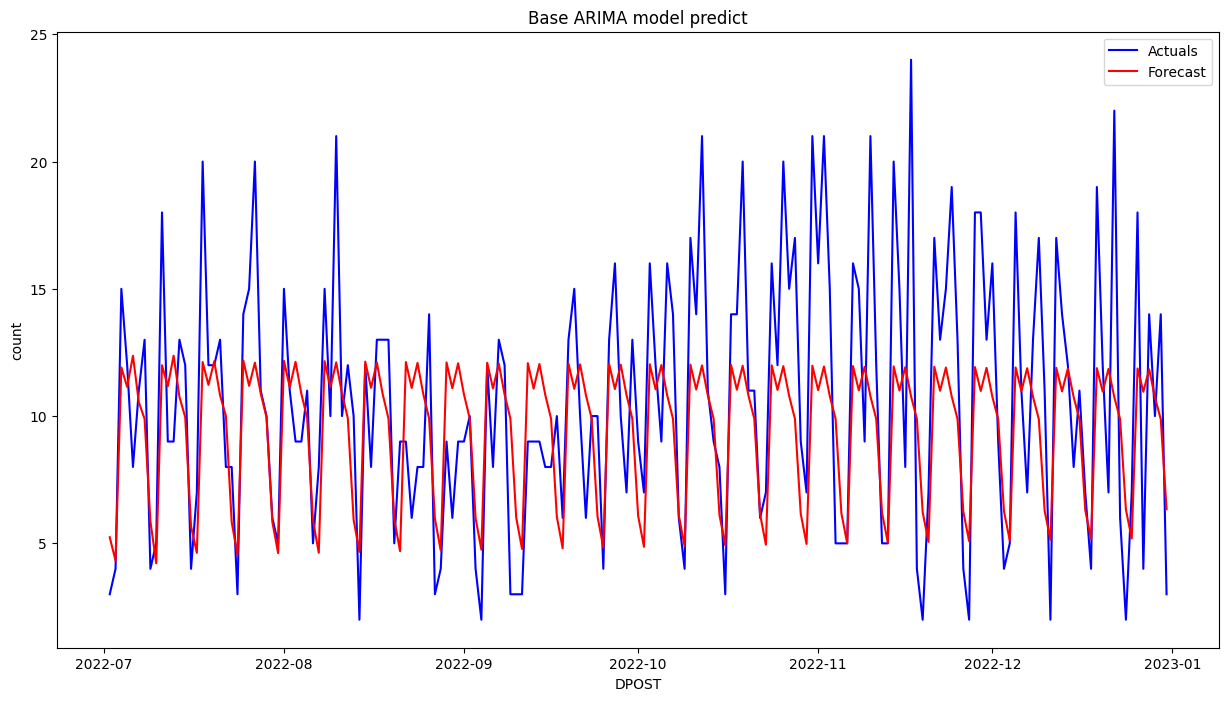

In [28]:
# Выведем получившиеся результаты
show_results(pred_df.loc[test_df.index], test_df, with_cols = True, title = 'Base ARIMA')
# Также отобразим средние значения реальных данных и предсказаний. чтобы выразить разницу в уровне
print(test_df['count'].mean(), pred_df.model_preds.mean())

Результат модели ARIMA оказался незначительно хуже можели експненциального сглаживания, при этом по графикам обеих моделей видно, что предсказания сдвинуты в нижнюю часть графика, о чем также свидетельствует разница в средних значениях рельных значений на тестовой выборке и предсказаний. Это вероятно является следствием влияния на обучение модели данных за 2020 и 2021 года  когда из-за пандемии COVID-19 значиетльно снижено было количество госпитализированных. Поскольку это является аномальным событием, которое не отражает обе динамики, то для дальнейших исследований исключим данные за эти года из обучения.
<br/>
Кроме того, для построения лучшего прогноза произведем преобразование временного ряда путем убирания из него составляющих внутригодовой сезонности, недельной сезонности, а также недельной волатильности. Посколько по графикам видно что волатльность поступления меняется в зависимости от общего количества поступивших за период - чем больше поступило, тем больше разброс, то раскладывать будем мультипликативно.

## Декомпозиция ряда и дальнейшие предсказания

In [26]:
# Класс для декомпозиции временного ряда с возможностью прогнозирования компонентов в будущее
class TrendRemover:
    
    # в конструкторе инициализируем списки компонентов
    def __init__(self):
        self.week_component = dict()
        self.day_component = dict()
        self.components = []
        self.vol_components = []
    
    # Функция для первичного разложения ряда, определения компонентов и преобразования поданного ряда
    def fit_transform(self, data, target='count', n_components = 5):
        # удалим из ряда данные за 2020 и 2021 год, т.к. они содержат выраженные аномалии связаные с пандемией COVID-19
        data_with_date = data[(data.index.year < 2020) | (
            data.index.year > 2021)].copy(deep=True)
        # Выделим признак даты из индекса для удобства дальнешего формирования признаков
        data_with_date['date'] = pd.to_datetime(
            data_with_date.index.to_pydatetime())
        # Создадим признак дня недели
        data_with_date['day_of_week'] = data_with_date.date.dt.day_of_week
        # CСоздадим признак дня года - основной признак по которому будем определять среднее значение для компонентов.
        data_with_date['day'] = data_with_date.date.dt.day_of_year
        
        # Список с днями года
        days = data_with_date['day'].unique()

        # цикл для создания компонентов с сужающимся окном скользящего среднего
        # Т.к. ряд имеет меняющуюся волатильность в зависиомсти от 
        # величины среднего значения за период, то будем использовать мультипликативный подход.
        # Каждый последующий компонент будте иметть окно в два раза уже предыдущего.
        for i in [round(365/(2**x)) for x in range(0, n_components)]:
            # Задаем компонент сколзящего среднего
            comp = data_with_date[target].rolling(i).mean()
            comp_df = pd.DataFrame(columns=['target'], index=comp.index)
            comp_df['target'] = comp
            comp_df = comp_df.dropna()
            comp_df['day'] = comp_df.index.day_of_year
            comp_dict = dict()
            for day in days:
                comp_dict[day] = comp_df[comp_df['day']
                                         == day]['target'].mean()
            self.components.append(comp_dict)
            data_with_date[target] = data_with_date.apply(
                lambda x: x[target] / comp_dict[x['day']], axis=1)
            
            # Задаем компонент волатильности за период, 
            # т.к. период волатильности в пределах месяца, то необходимо, 
            # чтобы окно захватывало месячный и недельный компоненты, 
            # поэтому при числе заданных компонентов меньше 6, 
            # будем уменьшать изначальное окно пропорционально разнице числа компонетнов с 6 
            vol_window = round(i if n_components > 5 else i / 2**(6 - n_components))
            max_month = data_with_date[target].rolling(vol_window).max().dropna()
            min_month = data_with_date[target].rolling(vol_window).min().dropna()
            min_max_df = pd.DataFrame(
                columns=['min, max'], index=max_month.index)
            min_max_df['min'] = min_month
            min_max_df['max'] = max_month
            min_max_df['day'] = min_max_df.index.day_of_year
            vol_component = dict()
            for day in days:
                curr = min_max_df[min_max_df['day'] == day]
                min = curr['min'].mean()
                max = curr['max'].mean()
                vol_component[day] = max - min
            self.vol_components.append(vol_component)
            data_with_date[target] = data_with_date.apply(
                lambda x: x[target] / vol_component[x['day']], axis=1)        
        
        
        #for day in days:
        #    self.day_component[day] = data_with_date[data_with_date['day'] == day][target].median()
        #data_with_date[target] = data_with_date.apply(
        #        lambda x: x[target] / self.day_component[x['day']], axis=1)   
        # Для возможнсти построения прогноза без дополнительных моделей
        # сформируем компонент недльной сезонности
        days_of_week = data_with_date.day_of_week.unique()
        for day in days_of_week:
            self.week_component[day] = data_with_date[data_with_date.day_of_week ==
                                                      day][target].mean()
        data_with_date[target] = data_with_date.apply(
                lambda x: x[target] / self.week_component[x['day_of_week']], axis=1)

        self.mean = data_with_date[target].mean()

        return self.transform(data = data, target = target)

    # Функция обратной трансформации признака
    # Умножает ряд на все компоненты в обратном порядке
    def revers_transform(self, data, target='count'):
        inner_data = pd.DataFrame(data.copy(deep=True))
        inner_data['date'] = pd.to_datetime(inner_data.index.to_pydatetime())
        inner_data['day'] = inner_data.date.dt.day_of_year
        inner_data['day_of_week'] = inner_data.date.dt.day_of_week
        
        inner_data[target] = inner_data.apply(
                lambda x: x[target] * self.week_component[x['day_of_week']], axis=1)
        
        for i in range(len(self.vol_components)-1, -1, -1):
            comp = self.vol_components[i]
            inner_data[target] = inner_data.apply(
                lambda x: x[target] * comp[x['day']], axis=1)
            comp = self.components[i]
            inner_data[target] = inner_data.apply(
                lambda x: x[target] * comp[x['day']], axis=1)

        return inner_data[target]

    # Функция трансформации ряда. Преобразует ряд разделяя его на уже cформированные ранее компоненты
    def transform(self, data, target='count'):
        inner_data = pd.DataFrame(data.copy(deep=True))
        inner_data['date'] = pd.to_datetime(inner_data.index.to_pydatetime())
        inner_data['day'] = inner_data.date.dt.day_of_year
        inner_data['day_of_week'] = inner_data.date.dt.day_of_week
        
        for i in range(len(self.components)-1, -1, -1):
            comp = self.components[i]
            inner_data[target] = inner_data.apply(
                lambda x: x[target] / comp[x['day']], axis=1)
            comp = self.vol_components[i]
            inner_data[target] = inner_data.apply(
                lambda x: x[target] / comp[x['day']], axis=1)
        
        inner_data[target] = inner_data.apply(
                lambda x: x[target] / self.week_component[x['day_of_week']], axis=1)

        return inner_data[target]
    
    # Функция возвращающая прогноз по декомпозированному ряду
    def get_day_component(self, data, target):
        inner_data = pd.DataFrame(data.copy(deep=True))
        inner_data['date'] = pd.to_datetime(inner_data.index.to_pydatetime())
        inner_data['day_of_week'] = inner_data.date.dt.day_of_week

        return inner_data.apply(
            lambda x: self.week_component[x['day_of_week']], axis=1)

    # Функция возвращающая прогноз с восттановленными компонентами, на основе компонента недельной сезонности
    def predict(self, data, target='count'):
        data[target] = self.mean

        return self.revers_transform(data, target = target)

Проверим работу созданного класса, сформируем тренировочную и тестовые выборки. Для тренировочной выборки проведем декомпозицию

In [27]:
train_df = df.iloc[:-183]
test_df = df.iloc[-183:]
tr = TrendRemover()
train_df['count'] = tr.fit_transform(train_df, target = 'count')

Теперь отобраим что получилось

<Axes: xlabel='DPOST'>

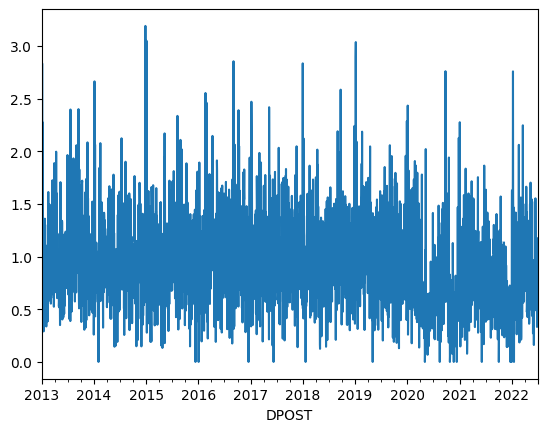

In [28]:
train_df['count'].plot()

Значения получились более однородными чем сырые данные.
<br/>
Попробуем сделать прогноз при помощи компонента недльной сезонности, созданного класса, и провести обратную трансформацию.

Metrics for Простой прогноз при помощи TrendRemover
MAE: 2.705
WAPE: 0.257


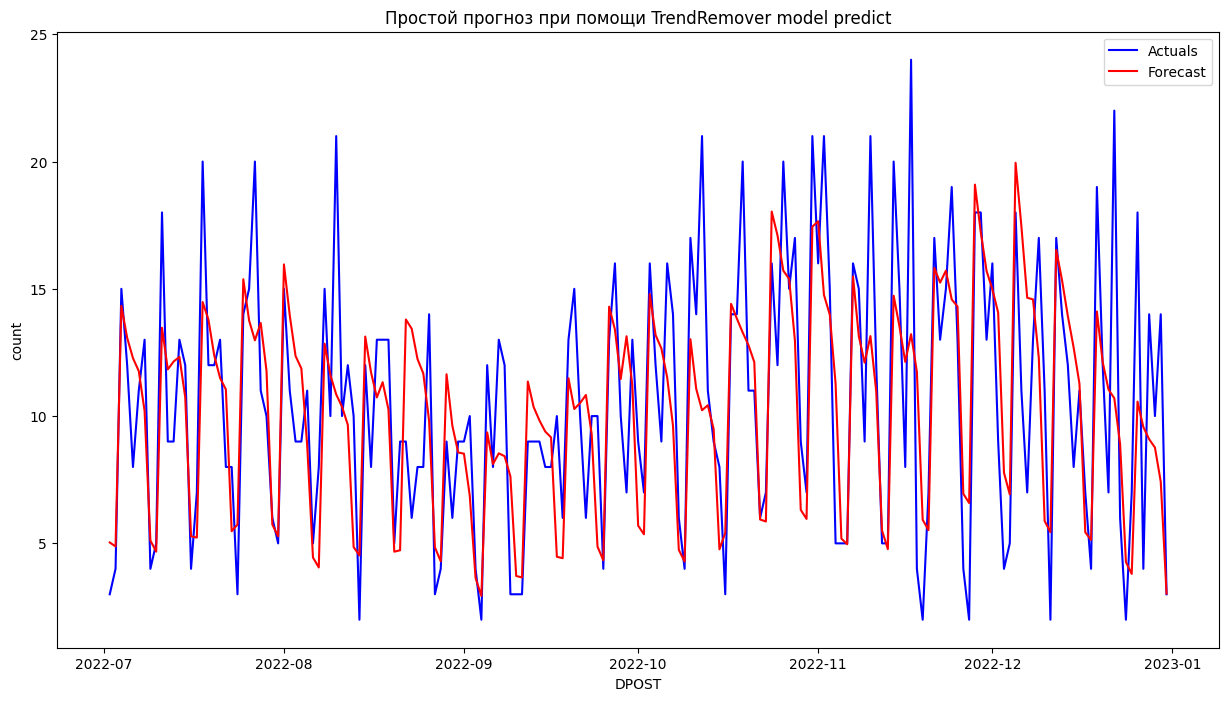

In [29]:
simple_pred = pd.DataFrame(index = test_df.index)
simple_pred['pred'] = tr.predict(simple_pred, target = 'pred')
show_results(simple_pred['pred'], test_df['count'], title = 'Простой прогноз при помощи TrendRemover')

Прогноз получился даже лучше чем прогноз самой лучше модели на необработанных данных.
<br/>
Таким образом наш класс TrendRemover уловил значиетльную часть дисперсии.
Посмотрим удастся ли улучшить предсказания при помощи моделей и уловить оставшуюся часть дисперсии.
<br/>
Также необходимо подобрать количество компонентов для разложения ряда, сделаем это перебрав значения от 1 до 8 и сравнив значения простого прогноза компонентом недельной сезонности на тренировочной выборке.
Побирать параметры декомпозиции и параметров модели будем на данных до 2020 года, т.к. данные за годы пандемии вносят сильные искажения.

In [30]:
for i in range(1, 9):
    tr = TrendRemover()
    train_df = df.iloc[:-1096]
    tr.fit_transform(train_df, target = 'count', n_components = i)
    simple_pred = pd.DataFrame(index = train_df.index)
    simple_pred['pred'] = 1
    simple_pred['pred'] = tr.predict(simple_pred, target = 'pred')
    simple_pred['count'] = train_df['count']
    print_metrics(simple_pred['pred'], simple_pred['count'], label = f'Simple preds with n_components = {i}')

Metrics for Simple preds with n_components = 1
MAE: 2.999
WAPE: 0.282
Metrics for Simple preds with n_components = 2
MAE: 3.003
WAPE: 0.281
Metrics for Simple preds with n_components = 3
MAE: 2.997
WAPE: 0.28
Metrics for Simple preds with n_components = 4
MAE: 2.982
WAPE: 0.279
Metrics for Simple preds with n_components = 5
MAE: 2.997
WAPE: 0.28
Metrics for Simple preds with n_components = 6
MAE: 3.062
WAPE: 0.284
Metrics for Simple preds with n_components = 7
MAE: 3.008
WAPE: 0.279
Metrics for Simple preds with n_components = 8
MAE: 3.401
WAPE: 0.304


Итак, оптимальное значение количества компонентов, исходя из показателя обеих метрик - это 4.
Пересоздадим тренировочную выборку с этим параметром

In [31]:
train_df = df.iloc[:-1096]
tr = TrendRemover()
train_df['count'] = tr.fit_transform(train_df, target = 'count', n_components = 4)

Визуализируем графики pacf и acf для выбора параметров ARIMA

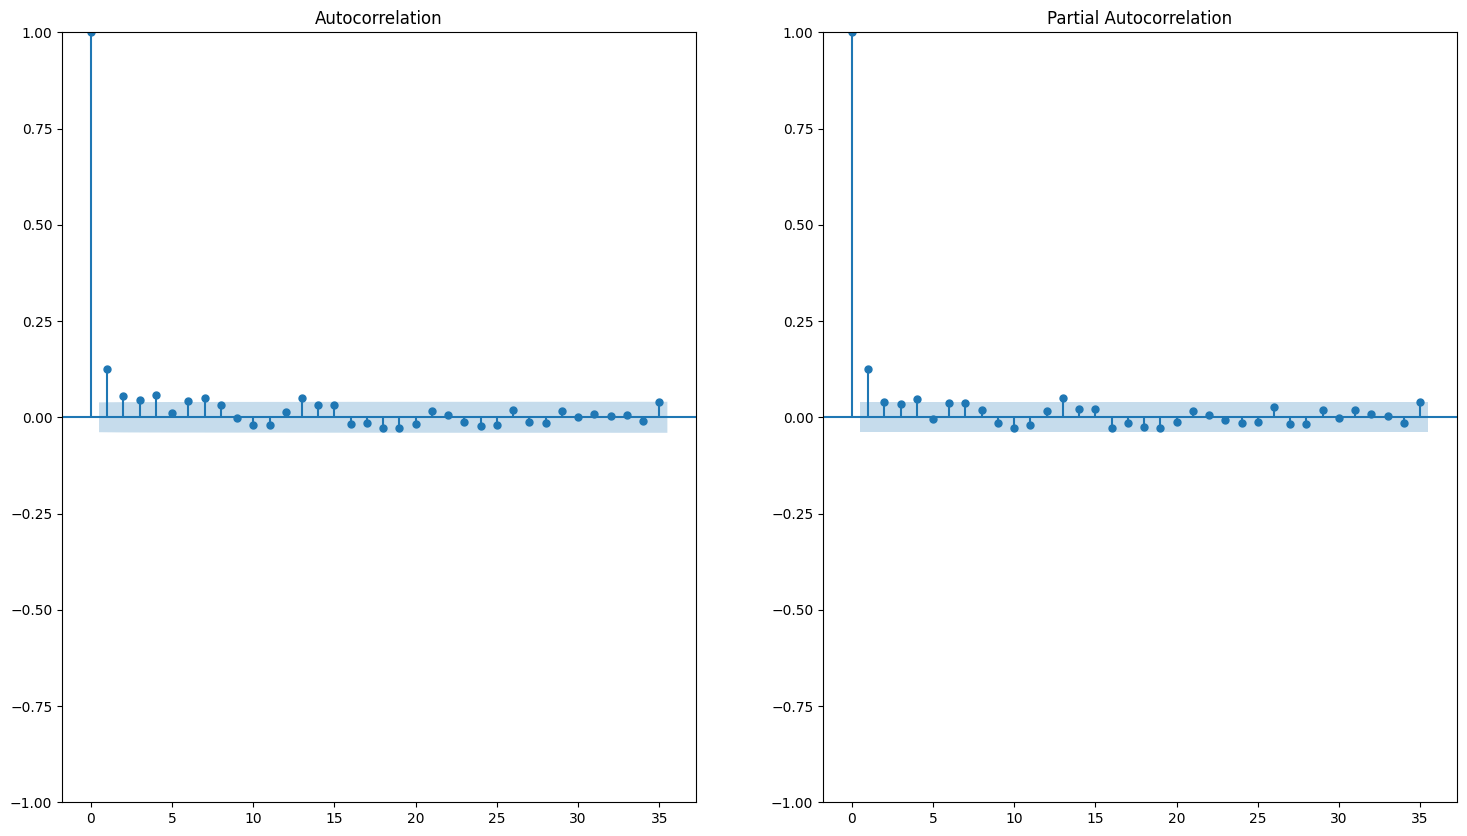

In [32]:
plot_acf_pacf(train_df['count'].dropna())

Значимых лагов корреляции практически не осталось, есть только лаги 1 и 1, сезонный компонент практически исчез
Проанализируем данные с попошью auto_arima со стартовыми параметрами (1, 0, 1) и (0, 0, 0, 7)

In [29]:
a_arima = auto_arima(y = train_df['count'].dropna() ,max_p = 6, max_q = 6, d=0, max_P = 2, m=7, max_Q=2, start_p = 1, start_q = 1, start_P=0, start_Q=0, max_order = 30 , seasonal = True, trace = True)
a_arima.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[7] intercept   : AIC=2463.997, Time=2.40 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=2510.751, Time=0.32 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=2470.167, Time=2.16 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=2473.534, Time=0.93 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=7626.407, Time=0.04 sec
 ARIMA(1,0,1)(1,0,0)[7] intercept   : AIC=2462.793, Time=5.86 sec
 ARIMA(1,0,1)(2,0,0)[7] intercept   : AIC=2462.870, Time=8.36 sec
 ARIMA(1,0,1)(1,0,1)[7] intercept   : AIC=inf, Time=5.80 sec
 ARIMA(1,0,1)(0,0,1)[7] intercept   : AIC=2462.973, Time=4.74 sec
 ARIMA(1,0,1)(2,0,1)[7] intercept   : AIC=inf, Time=16.76 sec
 ARIMA(0,0,1)(1,0,0)[7] intercept   : AIC=2473.331, Time=1.63 sec
 ARIMA(2,0,1)(1,0,0)[7] intercept   : AIC=2464.542, Time=4.40 sec
 ARIMA(1,0,2)(1,0,0)[7] intercept   : AIC=2463.202, Time=5.15 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=2506.499, Time=1.49 sec
 ARIMA(0,0,2)(1,0,0)[7] intercept   : AIC=

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 2556
Model:             SARIMAX(1, 0, 1)x(1, 0, [], 7)   Log Likelihood               -1226.396
Date:                            Thu, 20 Apr 2023   AIC                           2462.793
Time:                                    15:37:07   BIC                           2492.024
Sample:                                01-01-2013   HQIC                          2473.393
                                     - 12-31-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3261      0.085      3.855      0.000       0.160       0.492
ar.L1          0.6611      0.089      7.414      0.000       0.486       0.836
ma.L1         -0.5575      0.097     -5.751      0.000      -0.747      -0.367
ar.S.L7        0.0375      0.018      2.045      0.041       0.002       0.073
sigma2         0.1529      0.003     45.125      0.000       0.146       0.160
===================================================================================
Ljung-Box (L1) (Q):                   0.27   Jarque-Bera (JB):               466.86
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               1.06   Skew:                             0.65
Prob(H) (two-sided):                  0.43   Kurtosis:                         4.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Прогноз мделей будем изначально смотреть на декомпозированом ряде. Для этого разделим тренировучную выборку на обучающую и валидационную

In [34]:
train_val_df = train_df.iloc[:-183]
test_val_df = train_df.iloc[-183:]

В качестве базового уровня возьмем предсказание компонентом дневной сезонности обученного класса TrendRemover

Metrics for Simple Pred by mean day of week  values
MAE: 0.311
WAPE: 0.304


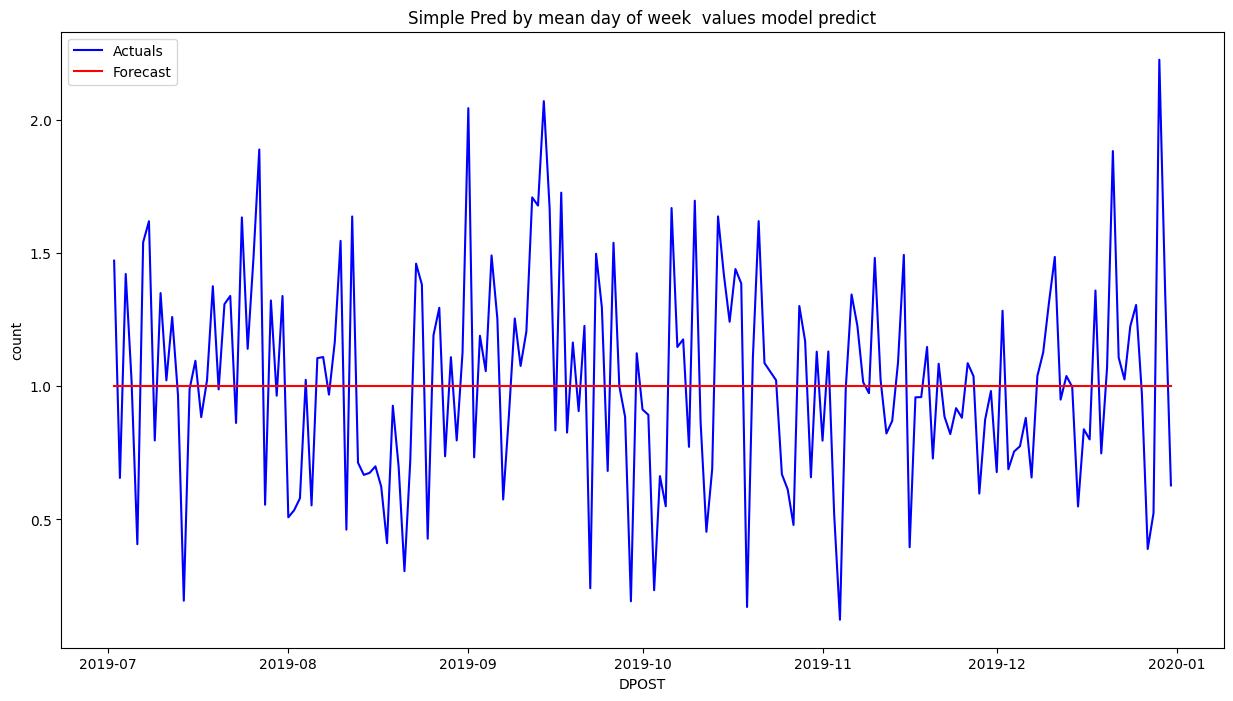

In [35]:
simple_pred_df = pd.DataFrame(index = test_val_df.index)
simple_pred_df['simple_pred'] = train_val_df['count'].mean()
simple_pred_df['simple_pred'] = tr.transform(tr.predict(simple_pred_df, target = 'simple_pred'), target = 'simple_pred')
show_results(simple_pred_df['simple_pred'], test_val_df['count'], title = "Simple Pred by mean day of week  values")

Теперь обучим модель арима на ряде с декомпозицией. К сожалению параметры подобранные auto_arima показывают результат хуже базового уровня. Поэтому путем ручного подбора параметров удалось найти сочетание в виде 1х лагов компонента скользящего среднего и авторегрессии, а также 5 лагов сезонного компонента MA и AR.

In [32]:
arima_model_with_trendremover = SARIMAX(train_val_df['count'], order = (1, 0, 1), seasonal_order = (1, 0, 0, 7), trend = 'c')
arima_model_fit_with_trendremover = arima_model_with_trendremover.fit(disp = False)
arima_model_fit_with_trendremover.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              count   No. Observations:                 2373
Model:             SARIMAX(1, 0, 1)x(1, 0, [], 7)   Log Likelihood               -1136.479
Date:                            Thu, 20 Apr 2023   AIC                           2282.958
Time:                                    15:37:57   BIC                           2311.818
Sample:                                01-01-2013   HQIC                          2293.463
                                     - 07-01-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3472      0.088      3.928      0.000       0.174       0.520
ar.L1          0.6349      0.094      6.739      0.000       0.450       0.820
ma.L1         -0.5253      0.102     -5.154      0.000      -0.725      -0.326
ar.S.L7        0.0475      0.019      2.518      0.012       0.011       0.084
sigma2         0.1526      0.003     43.997      0.000       0.146       0.159
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):               490.68
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):               1.05   Skew:                             0.68
Prob(H) (two-sided):                  0.49   Kurtosis:                         4.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Metrics for ARIMA with TrendRemover
MAE: 0.31
WAPE: 0.304


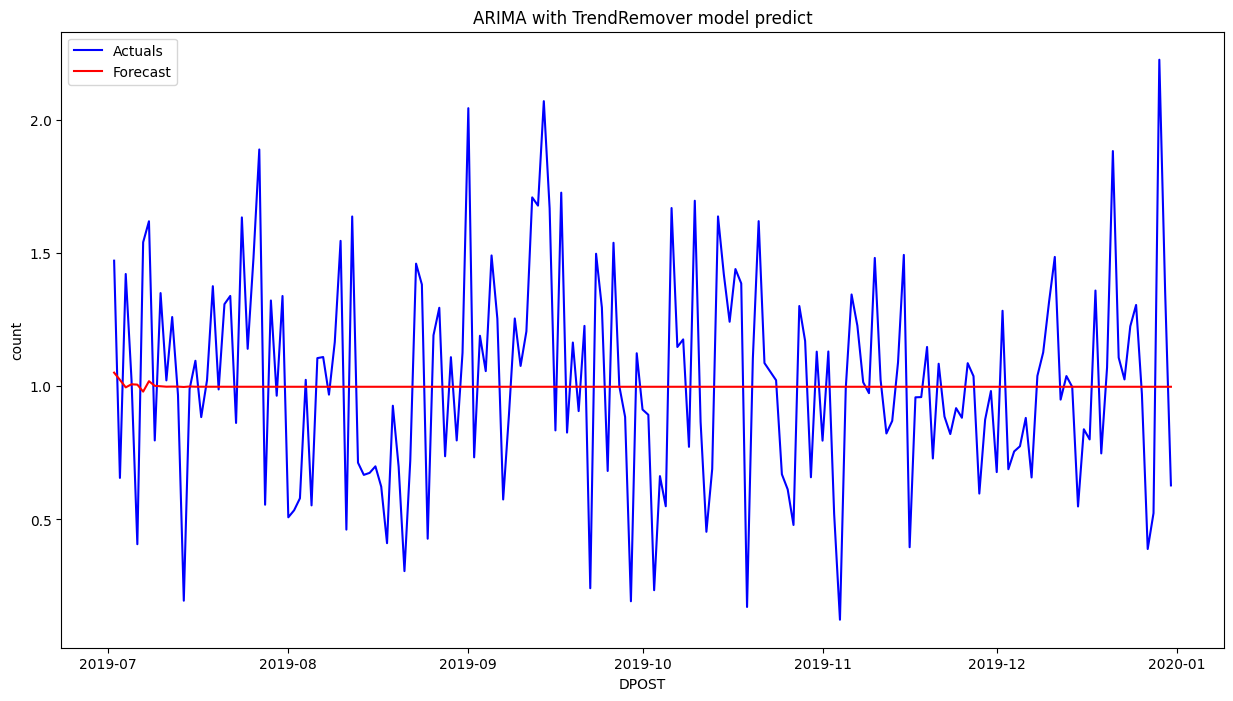

In [34]:
# Сформируем датафрейм для предсказаний модели со стоблцами предсказаний и реальных значений
pred_df = pd.DataFrame(index = df.index)
# Запишем предсказания 
pred_df["model_preds"] = arima_model_fit_with_trendremover.predict(start = test_val_df.index[0], end = test_val_df.index[-1])
# Затем реальные значения
pred_df['count'] = train_df['count']

show_results(pred_df.loc[test_val_df.index], test_val_df, with_cols = True, title = 'ARIMA with TrendRemover')

Как видно из графика ARIMA практически не уловила какие-либо закономерности и после небольших колебаний прогноз вышел в прямую линию.
<br/>
Попробуем в ручную подорать параметры дающие лучший прогноз

In [35]:
arima_model_with_trendremover = SARIMAX(train_val_df['count'], order = (56, 0, 56), seasonal_order = (0, 0, 0, 7))
arima_model_fit_with_trendremover = arima_model_with_trendremover.fit(disp = False)
arima_model_fit_with_trendremover.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  count   No. Observations:                 2373
Model:             SARIMAX(56, 0, 56)   Log Likelihood               -1105.785
Date:                Thu, 20 Apr 2023   AIC                           2437.570
Time:                        15:57:28   BIC                           3089.796
Sample:                    01-01-2013   HQIC                          2674.987
                         - 07-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5910      0.812     -0.728      0.467      -2.182       1.000
ar.L2         -0.7422      0.404     -1.839      0.066      -1.533       0.049
ar.L3         -0.8926      0.693     -1.288      0.198      -2.251       0.466
ar.L4         -0.9845      0.621     -1.587      0.113      -2.201       0.232
ar.L5         -1.2034      0.754     -1.597      0.110      -2.681       0.274
ar.L6         -1.3101      0.699     -1.875      0.061      -2.680       0.059
ar.L7         -1.4726      0.867     -1.697      0.090      -3.173       0.228
ar.L8         -1.6716      0.850     -1.966      0.049      -3.338      -0.005
ar.L9         -1.7398      0.883     -1.971      0.049      -3.470      -0.010
ar.L10        -1.8577      0.999     -1.859      0.063      -3.816       0.101
ar.L11        -1.9716      1.009     -1.953      0.051      -3.950       0.007
ar.L12        -2.0132      0.975     -2.065      0.039      -3.924      -0.102
ar.L13        -2.1370      1.190     -1.796      0.073      -4.469       0.195
ar.L14        -2.1603      0.984     -2.196      0.028      -4.088      -0.232
ar.L15        -2.1114      1.146     -1.843      0.065      -4.357       0.134
ar.L16        -2.1168      1.106     -1.914      0.056      -4.285       0.051
ar.L17        -2.0144      1.060     -1.900      0.057      -4.093       0.064
ar.L18        -1.9242      0.986     -1.951      0.051      -3.857       0.009
ar.L19        -1.8429      1.014     -1.817      0.069      -3.830       0.145
ar.L20        -1.6680      0.878     -1.899      0.058      -3.390       0.053
ar.L21        -1.4472      0.801     -1.808      0.071      -3.016       0.122
ar.L22        -1.3430      0.795     -1.689      0.091      -2.901       0.215
ar.L23        -1.0432      0.617     -1.690      0.091      -2.253       0.166
ar.L24        -0.7908      0.592     -1.335      0.182      -1.952       0.370
ar.L25        -0.5650      0.403     -1.403      0.161      -1.354       0.224
ar.L26        -0.2510      0.357     -0.704      0.482      -0.950       0.448
ar.L27        -0.0033      0.260     -0.013      0.990      -0.513       0.506
ar.L28         0.3275      0.238      1.377      0.169      -0.139       0.794
ar.L29         0.7043      0.391      1.799      0.072      -0.063       1.471
ar.L30         0.8994      0.459      1.958      0.050      -0.001       1.800
ar.L31         1.1434      0.535      2.138      0.033       0.095       2.192
ar.L32         1.3524      0.654      2.067      0.039       0.070       2.635
ar.L33         1.5248      0.731      2.086      0.037       0.092       2.957
ar.L34         1.7624      0.826      2.134      0.033       0.144       3.381
ar.L35         1.8067      0.899      2.009      0.045       0.044       3.569
ar.L36         1.9402      0.911      2.129      0.033       0.154       3.726
ar.L37         2.0567      0.998      2.062      0.039       0.102       4.012
ar.L38         2.0755      1.018      2.038      0.042       0.080       4.071
ar

Metrics for ARIMA with TrendRemover (Manual params)
MAE: 0.31
WAPE: 0.303


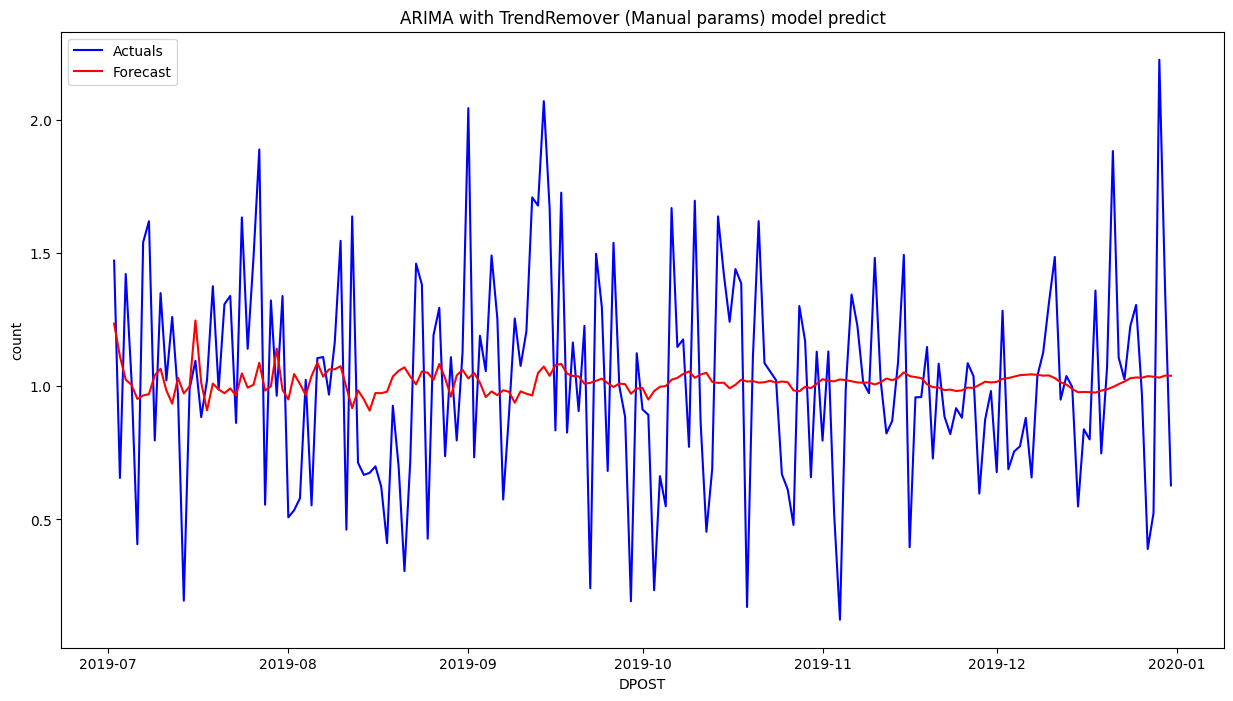

In [36]:
# Сформируем датафрейм для предсказаний модели со стоблцами предсказаний и реальных значений
pred_df = pd.DataFrame(index = df.index)
# Запишем предсказания 
pred_df["model_preds"] = arima_model_fit_with_trendremover.predict(start = test_val_df.index[0], end = test_val_df.index[-1])
# Затем реальные значения
pred_df['count'] = train_df['count']

show_results(pred_df.loc[test_val_df.index], test_val_df, with_cols = True, title = 'ARIMA with TrendRemover (Manual params)')

Параметры подобранные вручную показывают чуть лучший результат. Удалось превзойти базовый уровень, но всего на 1 десятую процента.
   
Теперь обучим модель экспоненциального сглаживания.

Metrics for Exponential smoothing with TrendRemover
MAE: 0.335
WAPE: 0.328


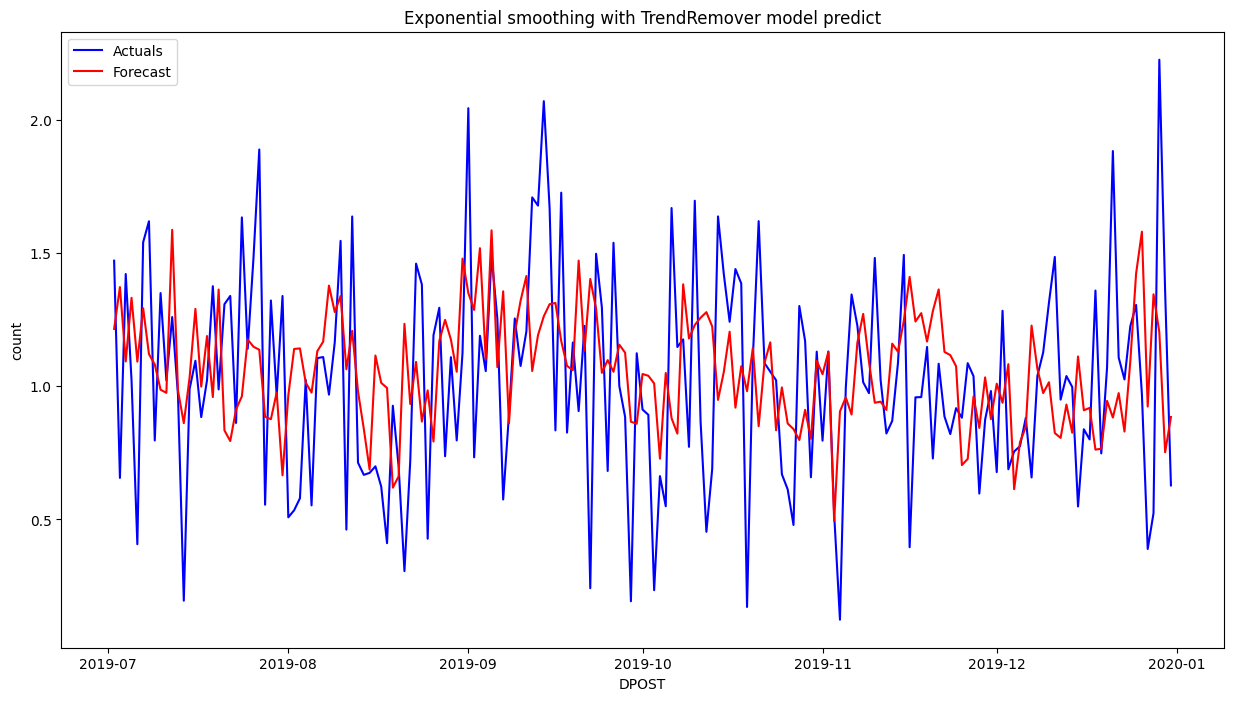

In [36]:
# Создадим модель
model = ExponentialSmoothing(
    train_val_df['count'], trend='add', seasonal='add', seasonal_periods=365)
# Обучим ее
model_fit = model.fit()

start = test_val_df.index[0]
end = test_val_df.index[-1]

# Сделаем предсказание
exp_forecast = model_fit.predict(start, end)

# Сохраним предсказание в тестовый датафрейм для удобства отображения
test_val_df['preds'] = exp_forecast

show_results(test_val_df['preds'], test_val_df['count'], title = 'Exponential smoothing with TrendRemover')

А вот модель экспоненциального сглаживания показала худший результат, причем с увеличением сезонного периода ухудшается и прогноз, несмотря на то, что график на первый вгляд выгялдит более похожим на реальные данные - но колебания оказывются такими, что дают прогноз худший чем прямая.
<br/>
<br/>
В связи с полученными результатами возникла гипотеза, что оставвшиеся после декомпозии данные являются белым шумом.\
Проведем тест Ljung-Box на булый шум.

In [37]:
import statsmodels.stats.diagnostic as diag
diag.acorr_ljungbox(test_val_df['count'], lags = 28, boxpierce = True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,0.583422,0.444974,0.573961,0.448689
2,0.611536,0.736558,0.601467,0.740275
3,2.848975,0.415501,2.778435,0.427062
4,5.001490,0.287145,4.861138,0.301845
5,5.019624,0.413490,4.878587,0.430877
6,6.581932,0.361244,6.373336,0.382693
7,7.700230,0.359768,7.437229,0.384817
8,11.626855,0.168645,11.151605,0.193256
9,11.627870,0.235110,11.152559,0.265397
10,12.214013,0.270989,11.700682,0.305588


Итак, по всем лагам значние p значиетльно больше порогового значения, значит мы не можем отвергнуть нулевую гипотезу и соотетственно данные предсталяют белый шум, а это значит, что без введения каких-либо дополнительных параметров улучшить прогноз нам не удастся.
   
  
## Добавление дополнительных признаков
  
     
В связи с этим добавим несколько дополнительных признаков, извлеченных из самого временного ряда, а также признак пандемии (хоть в данных для тренировки он и будет всегда равен 0, но возможно в тестовой выборке окажет вллияние.

In [38]:
# Словарь соответствия месяцам и праздничным дням
holydays_dict = {
    1: list(range(1, 10)),
    2: [23],
    3: [8],
    4: [],
    5: [1, 2, 3, 9, 10],
    6: [12],
    7: [],
    8: [],
    9: [1],
    10: [],
    11: [4],
    12: [31]
}
# Словарь соответствия месячам и дням после праздников
day_after_holydays_dict = {
    1: list(range(10, 18)),
    2: list(range(24, 29)),
    3: list(range(9, 12)),
    4: [],
    5: [4, 5] + list(range(11, 16)),
    6: [],
    7: [],
    8: [],
    9: [],
    10: [],
    11: list(range(5, 8)),
    12: []
}
# Словарь соответствия месячам и дням до праздников
days_before_holydays_dict = {
    1: [],
    2: [20, 21, 22],
    3: [6, 7],
    4: [27, 28, 29, 30],
    5: [],
    6: [],
    7: [],
    8: [],
    9: [],
    10: [],
    11: [1, 2, 3],
    12: [26, 27, 28, 29, 30]
}

covid_months ={
   2020: list(range(4,13)),
   2021: list(range(1,5)) + list(range(9,13))
}

# Функция для добавления признака прздничных дней


def holydays_add(date):
    month = date.month
    day = date.day
    result = 0
    if day in holydays_dict[month]:
        result = 1
    return result

# Функция для добавления признака дней после праздников


def day_after_holydays_add(date):
    month = date.month
    day = date.day
    result = 0
    if day in day_after_holydays_dict[month]:
        result = 1
    return result

# Функция для добавления признака дней до праздников


def day_before_holydays_add(date):
    month = date.month
    day = date.day
    result = 0
    if day in days_before_holydays_dict[month]:
        result = 1
    return result


def get_covid(date):
    result = 0
    if date.year in covid_months.keys():
        result = int(date.month in covid_months[date.year])
    return result


# Обновим датафрейм
df = data[['count', 'DPOST']].groupby(by='DPOST').count()
df = df.asfreq(freq='D')
df = df.fillna(0)
# Создадим признак даты для последующего извлечения признаков
df['Date'] = pd.to_datetime(df.index.to_pydatetime())
# Добавим признаки при помощи применения функций
df['holyday'] = df['Date'].apply(holydays_add)
df['day_after_holydays'] = df['Date'].apply(day_after_holydays_add)
df['day_before_holydays'] = df['Date'].apply(day_before_holydays_add)
df['COVID'] = df['Date'].apply(get_covid)
df['day_of_week'] = df.index.day_name()
df = pd.get_dummies(df, columns = ['day_of_week'])
# Удалим ненужный теперь признак даты
df = df.drop(['Date'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3652 entries, 2013-01-01 to 2022-12-31
Freq: D
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   count                  3652 non-null   float64
 1   holyday                3652 non-null   int64  
 2   day_after_holydays     3652 non-null   int64  
 3   day_before_holydays    3652 non-null   int64  
 4   COVID                  3652 non-null   int64  
 5   day_of_week_Friday     3652 non-null   uint8  
 6   day_of_week_Monday     3652 non-null   uint8  
 7   day_of_week_Saturday   3652 non-null   uint8  
 8   day_of_week_Sunday     3652 non-null   uint8  
 9   day_of_week_Thursday   3652 non-null   uint8  
 10  day_of_week_Tuesday    3652 non-null   uint8  
 11  day_of_week_Wednesday  3652 non-null   uint8  
dtypes: float64(1), int64(4), uint8(7)
memory usage: 196.2 KB


В качестве дополнительного признака для соственного интереса я решил доабить признак фаз луны виде процента освещенной поверхности, предварительно распрсенныей с сайта mirkosmosa.ru

In [39]:
moon_df = pd.read_csv('./moon.csv', sep=';', index_col = 'date', parse_dates = ['date'])
df_merged = pd.merge(df, moon_df, how='left', left_index=True, right_index=True)

In [40]:
# Разобъем вновь данные на тренировочную выборки и 
# затем на обучающую и валидационные выборки, предварительно произвдя декомпозицию
train_df = df_merged.iloc[:-1096]
test_df = df_merged.iloc[-183:]

tr = TrendRemover()
train_df['count'] = tr.fit_transform(train_df, target='count', n_components = 4)

train_val_df = train_df.iloc[:-183]
test_val_df = train_df.iloc[-183:]

Обучим модель ARIMA на данных с дополнительными признаками, поскоьку в модели експоненциального сглаживания не предусмотрены дополнительные регрессоры

In [62]:
arima_model_ex = SARIMAX(train_val_df['count'], train_val_df.drop('count', axis = 1), order = (1, 0, 1), seasonal_order = (0, 0, 0, 7))
arima_model_fit_ex = arima_model_ex.fit(disp=False)
arima_model_fit_ex.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  count   No. Observations:                 2373
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -1134.849
Date:                Thu, 20 Apr 2023   AIC                           2299.698
Time:                        18:23:47   BIC                           2386.277
Sample:                    01-01-2013   HQIC                          2331.213
                         - 07-01-2019                                         
Covariance Type:                  opg                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
holyday                  -0.0669      0.028     -2.423      0.015      -0.121      -0.013
day_after_holydays        0.0477      0.034      1.396      0.163      -0.019       0.115
day_before_holydays      -0.0069      0.039     -0.180      0.857      -0.082       0.069
COVID                 -1.153e-16        nan        nan        nan         nan         nan
day_of_week_Friday        0.9817      0.028     35.243      0.000       0.927       1.036
day_of_week_Monday        0.9723      0.030     32.199      0.000       0.913       1.031
day_of_week_Saturday      0.9872      0.023     43.464      0.000       0.943       1.032
day_of_week_Sunday        0.9868      0.024     40.353      0.000       0.939       1.035
day_of_week_Thursday      0.9788      0.030     32.404      0.000       0.920       1.038
day_of_week_Tuesday       0.9780      0.030     32.783      0.000       0.920       1.036
day_of_week_Wednesday     0.9833      0.030     32.935      0.000       0.925       1.042
moon_shine                0.0004      0.000      1.227      0.220      -0.000       0.001
ar.L1                     0.5336      0.109      4.890      0.000       0.320       0.748
ma.L1                    -0.4149      0.116     -3.575      0.000      -0.642      -0.187
sigma2                    0.1509      0.004     40.925      0.000       0.144       0.158
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               563.28
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.05   Skew:                             0.71
Prob(H) (two-sided):                  0.48   Kurtosis:                         4.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.01e+18. Standard errors may be unstable.
"""

Metrics for ARIMA with Exogenios feachures
MAE: 0.311
WAPE: 0.304


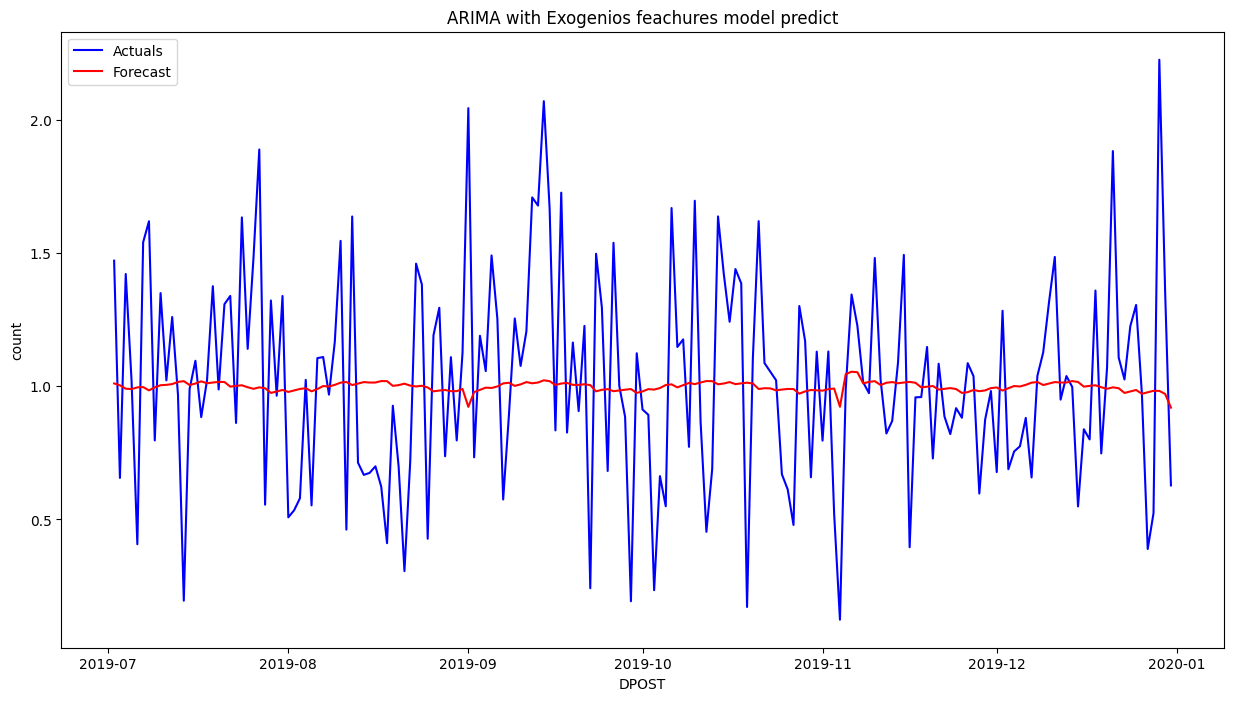

In [63]:
# Сформируем датафрейм для предсказаний модели со стоблцами предсказаний и реальных значений
pred_df = pd.DataFrame(index = test_val_df.index)
# Запишем предсказания
pred_df["model_preds"] = arima_model_fit_ex.predict(start = test_val_df.index[0], end = test_val_df.index[-1], exog = test_val_df.drop('count', axis = 1))
# Затем реальные значения
pred_df['count'] = df['count']


show_results(pred_df.loc[test_val_df.index], test_val_df, with_cols = True, title = 'ARIMA with Exogenios feachures')

При помощи модели ARIMA с дополнительными регрессорами прогноз улучшить не удалось
<br/>
<br/>
Теперь попробуем обучить еще модели - случайного леса, XGBoost и простой линейной регрессии. Поскольку сам ряд представляет собой белый шум, то будем прогнозировать используя только дополнительные признаки.
Поиск параметров будем производить при помощи RandomizedSearchCV, разбиение на кросвалидацию будем осуществлять при помощи TimtSeriesSplit из пакета sklearn.

In [83]:
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV

In [253]:

model = sklearn.ensemble.RandomForestRegressor(random_state = 5555)
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(3, 50, num = 20)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 4, 7, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 8]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

tscv = TimeSeriesSplit(n_splits = 3, test_size = 183)
rsearch_rfr = RandomizedSearchCV(estimator=model, cv=tscv,
                        param_distributions=random_grid, verbose = 3, scoring = 'neg_mean_absolute_error', n_iter = 50)
X = train_val_df.drop(['count'], axis = 1)
y =  train_val_df['count']
rsearch_rfr.fit(X, y)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV 1/3] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=7, n_estimators=100;, score=-0.317 total time=   3.2s
[CV 2/3] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=7, n_estimators=100;, score=-0.303 total time=   3.4s
[CV 3/3] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=7, n_estimators=100;, score=-0.280 total time=   3.7s
[CV 1/3] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=600;, score=-0.300 total time=   0.6s
[CV 2/3] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=600;, score=-0.305 total time=   0.6s
[CV 3/3] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=600;, score=-0.295 total time=   0.6s
[CV 1

[CV 3/3] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=7, n_estimators=600;, score=-0.281 total time=  15.1s
[CV 1/3] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=600;, score=-0.296 total time=   1.9s
[CV 2/3] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=600;, score=-0.298 total time=   2.0s
[CV 3/3] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=600;, score=-0.286 total time=   2.1s
[CV 1/3] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=-0.298 total time=   0.5s
[CV 2/3] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=-0.304 total time=   0.5s
[CV 3/3] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples

[CV 2/3] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=800;, score=-0.303 total time=   1.4s
[CV 3/3] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=800;, score=-0.292 total time=   1.4s
[CV 1/3] END bootstrap=False, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=700;, score=-0.308 total time=  17.9s
[CV 2/3] END bootstrap=False, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=700;, score=-0.307 total time=  18.7s
[CV 3/3] END bootstrap=False, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=700;, score=-0.279 total time=  19.4s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=900;, score=-0.292 total time=  21.4s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=auto, min_samples

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=183),
                   estimator=RandomForestRegressor(random_state=5555),
                   n_iter=50,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [3, 5, 7, 10, 12, 15, 17,
                                                      20, 22, 25, 27, 30, 32,
                                                      35, 37, 40, 42, 45, 47,
                                                      50, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4, 8],
                                        'min_samples_split': [2, 4, 7, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   scoring='neg_mean_absolute_error', verbose=3)

In [254]:
rsearch_rfr.best_params_

{'n_estimators': 500,
 'min_samples_split': 7,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 40,
 'bootstrap': True}

In [65]:
model = sklearn.ensemble.RandomForestRegressor(**{'n_estimators': 700,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 7,
 'bootstrap': False}, random_state = 5555)
model.fit(train_val_df.dropna().drop(['count'], axis = 1), train_val_df.dropna()['count'])

RandomForestRegressor(bootstrap=False, max_depth=7, max_features='sqrt',
                      min_samples_leaf=2, min_samples_split=10,
                      n_estimators=700, random_state=5555)

Поскольку для проноза нам необходимо использовать дополнительные параметры - значения ряда в прошлом, то при прогнозировании придется добавлять их из уже раннее спрогнозированных моделей. Для этих целей напишем функцию, которая будет в цикле производить прогноз с шагом один и добавлять его к прошлым значениям.

count
Metrics for Random Forest Regressor
MAE: 0.305
WAPE: 0.298


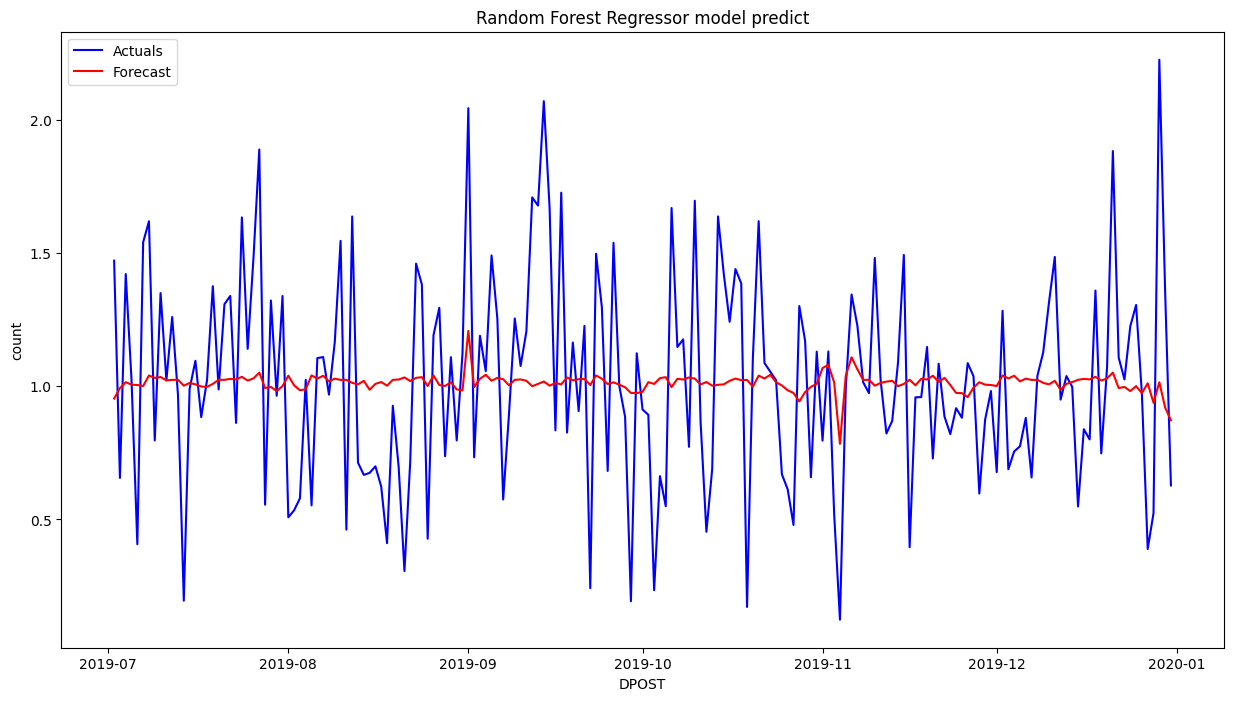

In [67]:
pred_df = pd.DataFrame(index = test_val_df.index)
pred_df['preds'] = model.predict(test_val_df.drop('count', axis = 1))
show_results(pred_df['preds'], test_val_df['count'],
             title='Random Forest Regressor')

Итак, Случайный лес показал улучшение значения метрик, чем базовый уровень. На графике видно, что это произошло за счет нескольких пиков вниз и одного вверх - которые обусловенные дополнительными признаками. Посмторим что же удастся сделать xgboost

In [68]:
#!pip install xgboost
import xgboost

In [87]:
model = xgboost.XGBRegressor(random_state = 5555)
param_grid = {
    'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)],
    # Learning rate shrinks the weights to make the boosting process more conservative
    "learning_rate": [0.0001,0.001, 0.01, 0.1, 1] ,
    # Maximum depth of the tree, increasing it increases the model complexity.
    "max_depth": range(3,30,3),
    # Gamma specifies the minimum loss reduction required to make a split.
    "gamma": [i/10.0 for i in range(0,5)],
    # Percentage of columns to be randomly samples for each tree.
    "colsample_bytree": [i/10.0 for i in range(3,10)],
    # reg_alpha provides l1 regularization to the weight, higher values result in more conservative models
    "reg_alpha": [1e-5, 1e-2, 0.1, 1, 10, 100],
    # reg_lambda provides l2 regularization to the weight, higher values result in more conservative models
    "reg_lambda": [1e-5, 1e-2, 0.1, 1, 10, 100]}

tscv = TimeSeriesSplit(n_splits = 3, test_size = 183)
rsearch_xgb = RandomizedSearchCV(estimator=model, cv=tscv,
                        param_distributions=param_grid, verbose = 3, scoring = 'neg_mean_absolute_error', n_iter = 100)
X = train_val_df.drop(['count'], axis = 1)
y =  train_val_df['count']
rsearch_xgb.fit(X, y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 1/3] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=27, n_estimators=500, reg_alpha=1, reg_lambda=0.1;, score=-0.298 total time=   1.0s
[CV 2/3] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=27, n_estimators=500, reg_alpha=1, reg_lambda=0.1;, score=-0.311 total time=   1.0s
[CV 3/3] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=27, n_estimators=500, reg_alpha=1, reg_lambda=0.1;, score=-0.286 total time=   0.8s
[CV 1/3] END colsample_bytree=0.9, gamma=0.0, learning_rate=0.01, max_depth=27, n_estimators=1000, reg_alpha=0.01, reg_lambda=0.1;, score=-0.310 total time=   2.1s
[CV 2/3] END colsample_bytree=0.9, gamma=0.0, learning_rate=0.01, max_depth=27, n_estimators=1000, reg_alpha=0.01, reg_lambda=0.1;, score=-0.318 total time=   2.3s
[CV 3/3] END colsample_bytree=0.9, gamma=0.0, learning_rate=0.01, max_depth=27, n_estimators=1000, reg_alpha=0.01, reg_lambda=0.1;, 

[CV 1/3] END colsample_bytree=0.3, gamma=0.4, learning_rate=0.01, max_depth=6, n_estimators=800, reg_alpha=1, reg_lambda=1;, score=-0.299 total time=   0.4s
[CV 2/3] END colsample_bytree=0.3, gamma=0.4, learning_rate=0.01, max_depth=6, n_estimators=800, reg_alpha=1, reg_lambda=1;, score=-0.307 total time=   0.4s
[CV 3/3] END colsample_bytree=0.3, gamma=0.4, learning_rate=0.01, max_depth=6, n_estimators=800, reg_alpha=1, reg_lambda=1;, score=-0.291 total time=   0.4s
[CV 1/3] END colsample_bytree=0.9, gamma=0.4, learning_rate=0.01, max_depth=21, n_estimators=200, reg_alpha=0.1, reg_lambda=1e-05;, score=-0.296 total time=   0.4s
[CV 2/3] END colsample_bytree=0.9, gamma=0.4, learning_rate=0.01, max_depth=21, n_estimators=200, reg_alpha=0.1, reg_lambda=1e-05;, score=-0.319 total time=   0.6s
[CV 3/3] END colsample_bytree=0.9, gamma=0.4, learning_rate=0.01, max_depth=21, n_estimators=200, reg_alpha=0.1, reg_lambda=1e-05;, score=-0.293 total time=   0.3s
[CV 1/3] END colsample_bytree=0.5, ga

[CV 1/3] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=12, n_estimators=1000, reg_alpha=1, reg_lambda=100;, score=-0.319 total time=   0.4s
[CV 2/3] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=12, n_estimators=1000, reg_alpha=1, reg_lambda=100;, score=-0.352 total time=   0.4s
[CV 3/3] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=12, n_estimators=1000, reg_alpha=1, reg_lambda=100;, score=-0.344 total time=   0.4s
[CV 1/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=9, n_estimators=1000, reg_alpha=1, reg_lambda=10;, score=-0.297 total time=   1.1s
[CV 2/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=9, n_estimators=1000, reg_alpha=1, reg_lambda=10;, score=-0.310 total time=   1.1s
[CV 3/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=9, n_estimators=1000, reg_alpha=1, reg_lambda=10;, score=-0.287 total time=   1.1s
[CV 1/3] END colsample_bytree=0.8, ga

[CV 2/3] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.001, max_depth=15, n_estimators=400, reg_alpha=100, reg_lambda=1;, score=-0.447 total time=   0.2s
[CV 3/3] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.001, max_depth=15, n_estimators=400, reg_alpha=100, reg_lambda=1;, score=-0.431 total time=   0.1s
[CV 1/3] END colsample_bytree=0.8, gamma=0.3, learning_rate=1, max_depth=12, n_estimators=400, reg_alpha=1, reg_lambda=1;, score=-0.300 total time=   0.5s
[CV 2/3] END colsample_bytree=0.8, gamma=0.3, learning_rate=1, max_depth=12, n_estimators=400, reg_alpha=1, reg_lambda=1;, score=-0.318 total time=   0.5s
[CV 3/3] END colsample_bytree=0.8, gamma=0.3, learning_rate=1, max_depth=12, n_estimators=400, reg_alpha=1, reg_lambda=1;, score=-0.291 total time=   0.6s
[CV 1/3] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.0001, max_depth=9, n_estimators=300, reg_alpha=1e-05, reg_lambda=0.01;, score=-0.498 total time=   0.2s
[CV 2/3] END colsample_bytree=0.4, gamma=0.2, l

[CV 2/3] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=900, reg_alpha=0.01, reg_lambda=0.01;, score=-0.312 total time=   0.4s
[CV 3/3] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=900, reg_alpha=0.01, reg_lambda=0.01;, score=-0.285 total time=   0.4s
[CV 1/3] END colsample_bytree=0.7, gamma=0.0, learning_rate=1, max_depth=15, n_estimators=100, reg_alpha=0.01, reg_lambda=100;, score=-0.303 total time=   0.1s
[CV 2/3] END colsample_bytree=0.7, gamma=0.0, learning_rate=1, max_depth=15, n_estimators=100, reg_alpha=0.01, reg_lambda=100;, score=-0.318 total time=   0.1s
[CV 3/3] END colsample_bytree=0.7, gamma=0.0, learning_rate=1, max_depth=15, n_estimators=100, reg_alpha=0.01, reg_lambda=100;, score=-0.295 total time=   0.1s
[CV 1/3] END colsample_bytree=0.9, gamma=0.0, learning_rate=0.01, max_depth=24, n_estimators=200, reg_alpha=100, reg_lambda=0.01;, score=-0.302 total time=   0.1s
[CV 2/3] END colsample_bytree=0.9

[CV 2/3] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.0001, max_depth=9, n_estimators=500, reg_alpha=100, reg_lambda=100;, score=-0.547 total time=   0.2s
[CV 3/3] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.0001, max_depth=9, n_estimators=500, reg_alpha=100, reg_lambda=100;, score=-0.529 total time=   0.2s
[CV 1/3] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.001, max_depth=6, n_estimators=800, reg_alpha=0.1, reg_lambda=100;, score=-0.335 total time=   0.3s
[CV 2/3] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.001, max_depth=6, n_estimators=800, reg_alpha=0.1, reg_lambda=100;, score=-0.372 total time=   0.3s
[CV 3/3] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.001, max_depth=6, n_estimators=800, reg_alpha=0.1, reg_lambda=100;, score=-0.363 total time=   0.3s
[CV 1/3] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.1, max_depth=12, n_estimators=200, reg_alpha=10, reg_lambda=1;, score=-0.299 total time=   0.1s
[CV 2/3] END colsample_bytree=

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=183),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=Non...
                   n_iter=100,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5, 0.6,
                                                             0.7, 0.8, 0.9],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.0001, 0.001, 0.01,
                                                          0.1, 1],
                                        'max_depth': range(3, 30, 3),
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000],
                                        'reg_alpha': [1e-05, 0.01, 0.1, 1, 10,
                                                      100],
                                        'reg_lambda': [1e-05, 0.01, 0.1, 1, 10,
                                                       100]},
                   scoring='neg_mean_absolute_error', verbose=3)

In [88]:
rsearch_xgb.best_params_

{'reg_lambda': 10,
 'reg_alpha': 0.1,
 'n_estimators': 700,
 'max_depth': 3,
 'learning_rate': 0.1,
 'gamma': 0.2,
 'colsample_bytree': 0.4}

In [89]:
model = xgboost.XGBRegressor(**{'reg_lambda': 10,
 'reg_alpha': 0.1,
 'n_estimators': 700,
 'max_depth': 3,
 'learning_rate': 0.1,
 'gamma': 0.2,
 'colsample_bytree': 0.4}, random_state = 5555)
model.fit(train_val_df.dropna().drop(['count'], axis = 1), train_val_df.dropna()['count'])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.4, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.2, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=700, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=5555, ...)

Metrics for XGB Regressor
MAE: 0.303
WAPE: 0.297


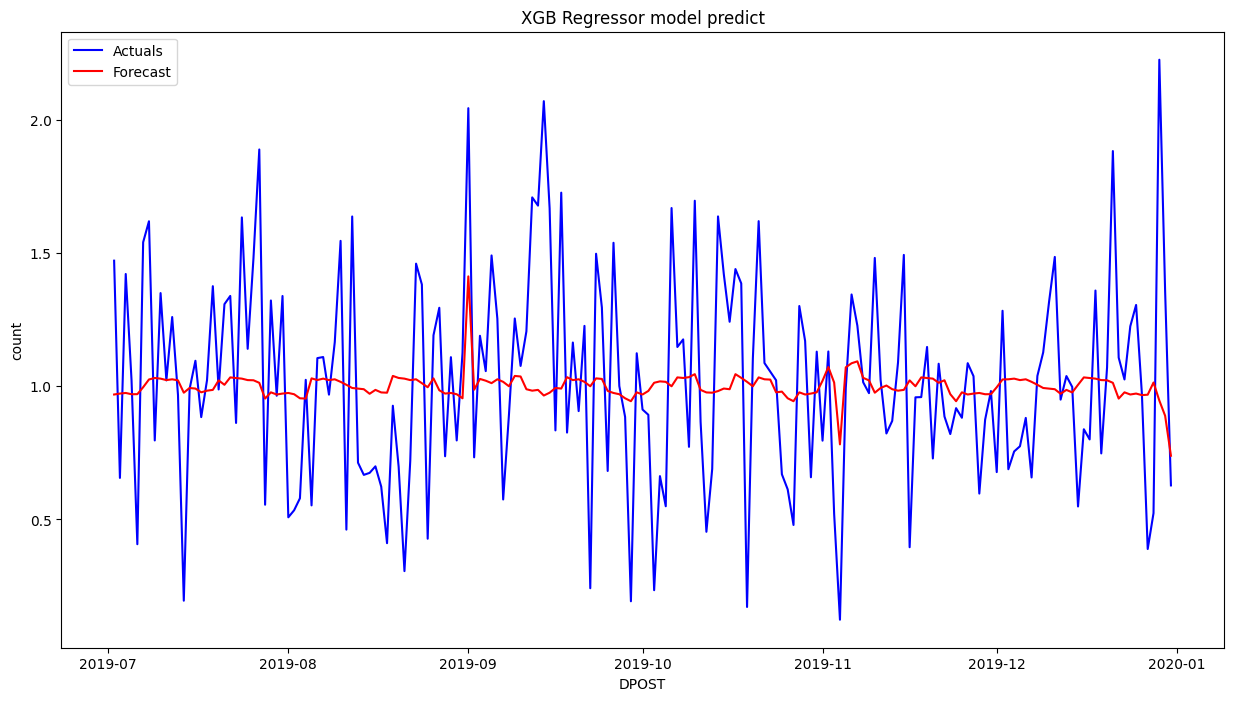

In [90]:
pred_df = pd.DataFrame(index = test_val_df.index)
pred_df['preds'] = model.predict(test_val_df.drop('count', axis = 1))
show_results(pred_df['preds'], test_val_df['count'],
             title='XGB Regressor')

Модель XGBRegressor также показала себя лучше базового уровня, осталось проверить линейную регрессию

count
Metrics for Linear Regression
MAE: 0.31
WAPE: 0.304


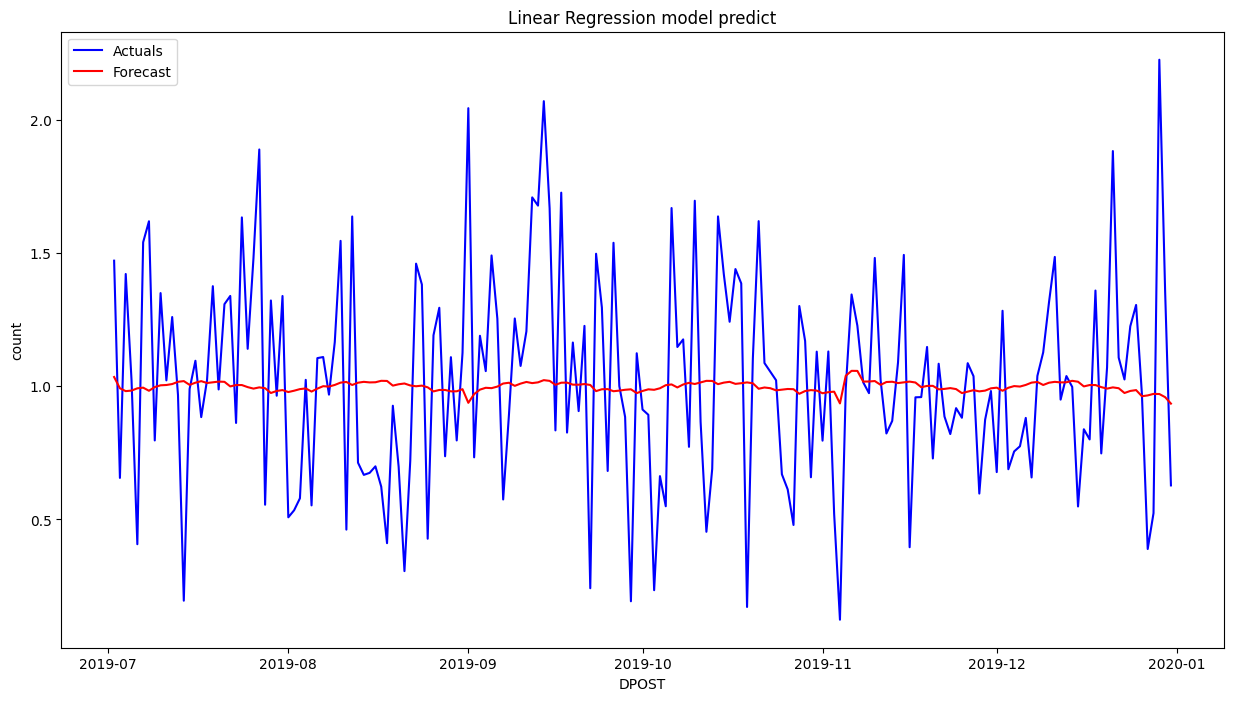

In [74]:
model = sklearn.linear_model.LinearRegression()
model.fit(train_val_df.dropna().drop(['count'], axis = 1), train_val_df.dropna()['count'])
pred_df = pd.DataFrame(index = test_val_df.index)
pred_df['preds'] = model.predict(test_val_df.drop('count', axis = 1))
show_results(pred_df['preds'], test_val_df['count'],
             title='Linear Regression')

Линейная регрессия не дала существенного улучшения результата по сравнению с базовым уровнем.

## Приступим к финальному тестированию моделей на тестовой выборке без декомпозиции ##

Пересоздадим тренировочную и тестовые выборки, на этот раз в тренировочную включим все вплоть до последнего полугодия 2022 года, на котором и будем проверять модели

In [102]:
train_df = df_merged.iloc[:-183]
test_df = df_merged.iloc[-183:]
tr = TrendRemover()
train_df['count'] = tr.fit_transform(train_df, target='count', n_components = 4)

Визуализируем простой прогноз классом TrendRemover

Metrics for Simple predict by Trend remover
MAE: 2.676
WAPE: 0.254


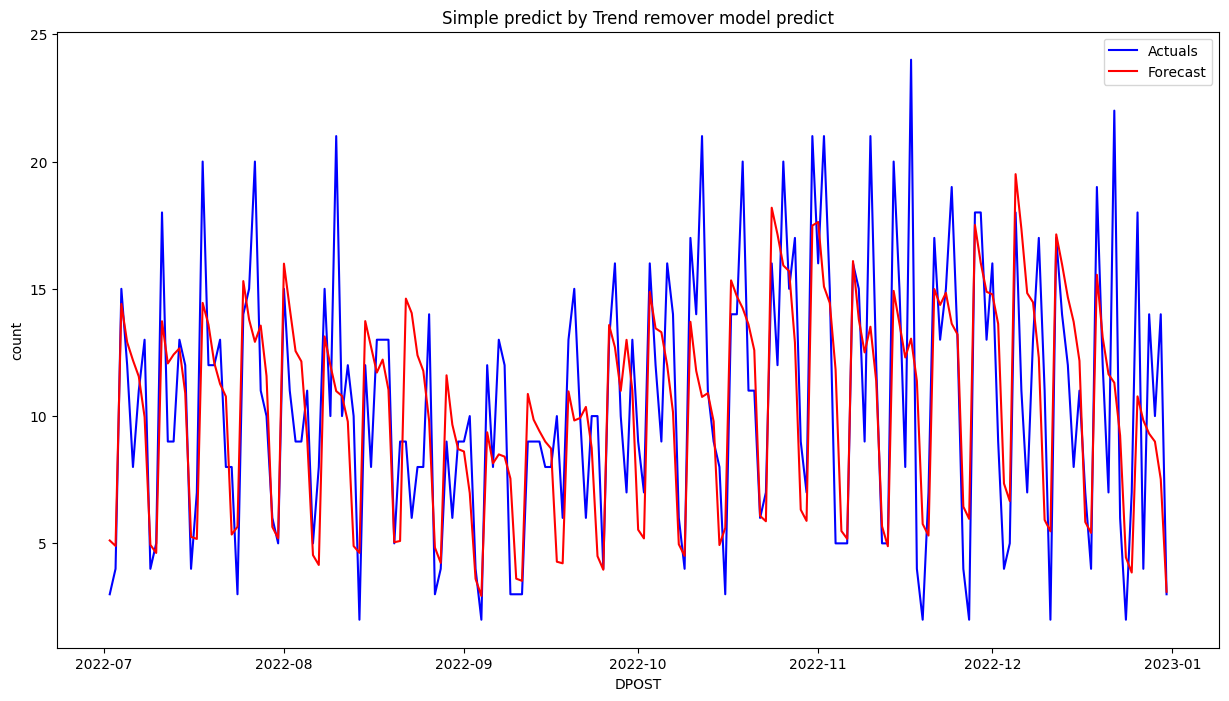

In [95]:
simple_df = pd.DataFrame(index = test_df.index)
show_results(tr.predict(simple_df, target = 'pred'), test_df['count'], title = 'Simple predict by Trend remover')

Видно значительное улучшение прогноза по сравнению с baseline и моделями обученными на ряде без декомпозиции
   
   
Посмотрим на результат ARIMA с дополнительными регрессорами

In [96]:
arima_model_ex = SARIMAX(train_df['count'], train_df.drop(
    'count', axis=1), order=(1, 0, 1), seasonal_order=(0, 0, 0, 7))
arima_model_fit_ex = arima_model_ex.fit(disp=False)
arima_model_fit_ex.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  count   No. Observations:                 3469
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -1660.740
Date:                Thu, 20 Apr 2023   AIC                           3351.480
Time:                        19:13:38   BIC                           3443.755
Sample:                    01-01-2013   HQIC                          3384.427
                         - 07-01-2022                                         
Covariance Type:                  opg                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
holyday                  -0.0439      0.024     -1.797      0.072      -0.092       0.004
day_after_holydays        0.0562      0.029      1.926      0.054      -0.001       0.113
day_before_holydays      -0.0300      0.033     -0.916      0.360      -0.094       0.034
COVID                    -0.3025      0.028    -10.831      0.000      -0.357      -0.248
day_of_week_Friday        0.9797      0.025     39.364      0.000       0.931       1.029
day_of_week_Monday        0.9440      0.026     36.913      0.000       0.894       0.994
day_of_week_Saturday      0.9682      0.021     46.442      0.000       0.927       1.009
day_of_week_Sunday        0.9819      0.022     45.609      0.000       0.940       1.024
day_of_week_Thursday      0.9683      0.026     36.797      0.000       0.917       1.020
day_of_week_Tuesday       0.9626      0.026     37.067      0.000       0.912       1.013
day_of_week_Wednesday     0.9594      0.026     37.000      0.000       0.909       1.010
moon_shine                0.0005      0.000      1.875      0.061   -2.22e-05       0.001
ar.L1                     0.6396      0.059     10.766      0.000       0.523       0.756
ma.L1                    -0.4940      0.066     -7.447      0.000      -0.624      -0.364
sigma2                    0.1535      0.003     48.365      0.000       0.147       0.160
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):               663.95
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                             0.68
Prob(H) (two-sided):                  0.94   Kurtosis:                         4.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Metrics for ARIMA with Exogenios feachures
MAE: 2.676
WAPE: 0.254


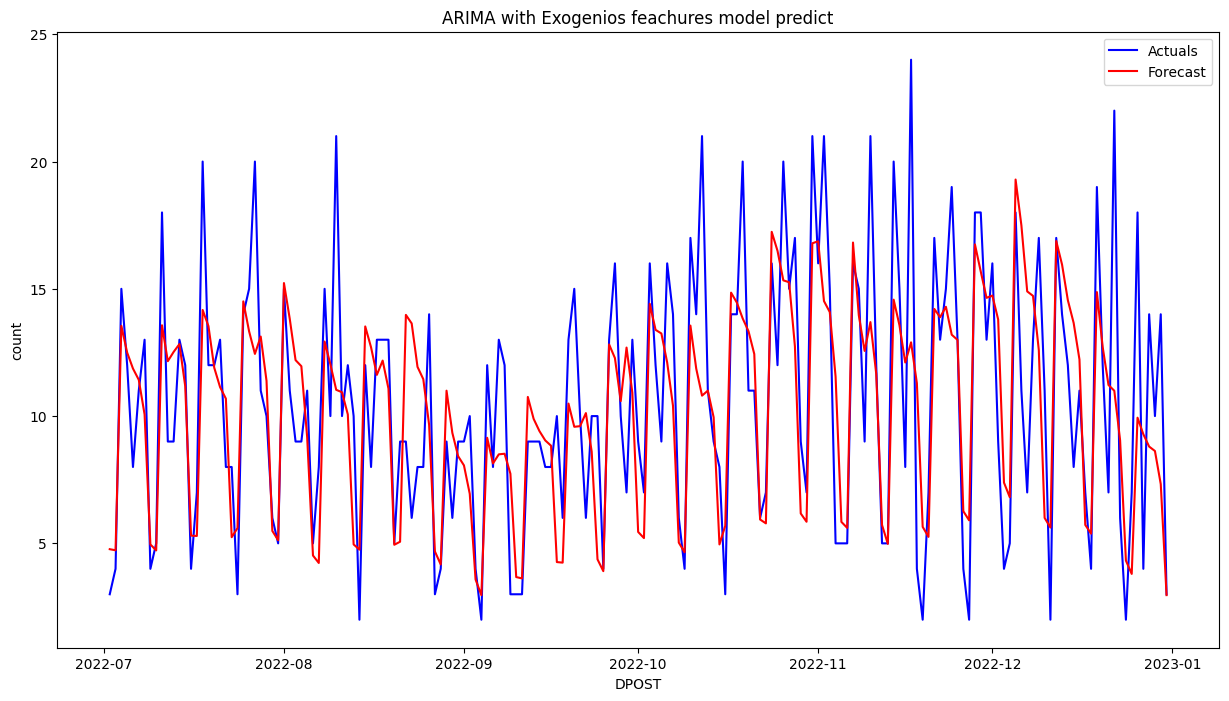

In [97]:
# Сформируем датафрейм для предсказаний модели со стоблцами предсказаний и реальных значений
pred_df = pd.DataFrame(index = test_df.index)
# Запишем предсказания
pred_df["model_preds"] = tr.revers_transform(arima_model_fit_ex.predict(start = test_df.index[0], end = test_df.index[-1], exog = test_df.drop('count', axis = 1)), target = 'predicted_mean')
# Затем реальные значения
pred_df['count'] = df['count']

show_results(pred_df.loc[test_df.index], pred_df.loc[test_df.index], with_cols = True, title = 'ARIMA with Exogenios feachures')

Результат у ARIMA такойже как у TrendRemover - то есть какого либо существенного вклада в прирост информации модель не дала.
     
     
Посмотрим на модель экспненциального сглаживания

Metrics for Exponential smoothing
MAE: 3.087
WAPE: 0.293


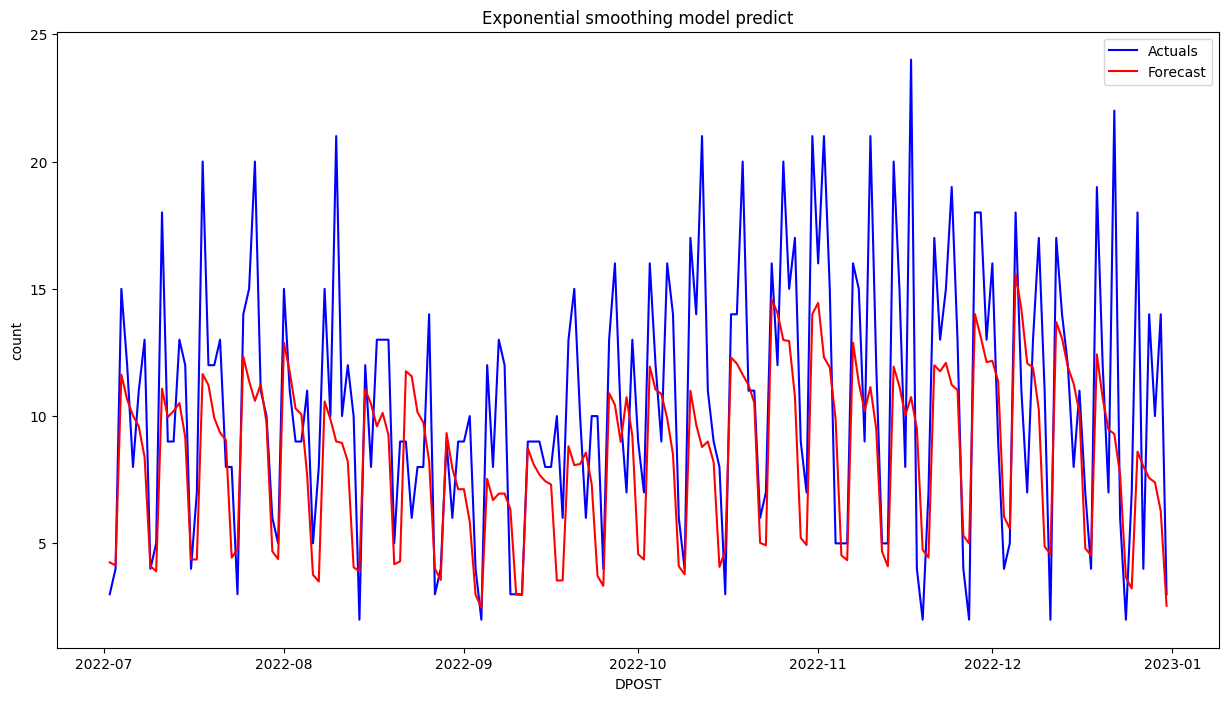

In [108]:
model = ExponentialSmoothing(
    train_df['count'], trend='add', seasonal='add', seasonal_periods=7)
# Обучим ее
model_fit = model.fit()

start = test_df.index[0]
end = test_df.index[-1]

# Сделаем предсказание
exp_forecast = model_fit.predict(start, end)

# Сохраним предсказание в датафрейм для удобства отображения
pred_df = pd.DataFrame(index = test_df.index)
pred_df['preds'] = exp_forecast

pred_df['preds'] = tr.revers_transform(pred_df, target = 'preds')

show_results(pred_df['preds'], test_df['count'], title = 'Exponential smoothing')

Прогноз не только не улучшился, но и значительно ухудшился.



Теперь посмотрим на самые перспективные ансамблевые модели

In [104]:
xgbr_model = xgboost.XGBRegressor(**{'reg_lambda': 10,
 'reg_alpha': 0.1,
 'n_estimators': 700,
 'max_depth': 3,
 'learning_rate': 0.1,
 'gamma': 0.2,
 'colsample_bytree': 0.4}, random_state = 5555)
xgbr_model.fit(train_df.dropna().drop(['count'], axis = 1), train_df.dropna()['count'])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.4, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.2, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=700, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=5555, ...)

Metrics for XGB Regressor Final
MAE: 2.682
WAPE: 0.255


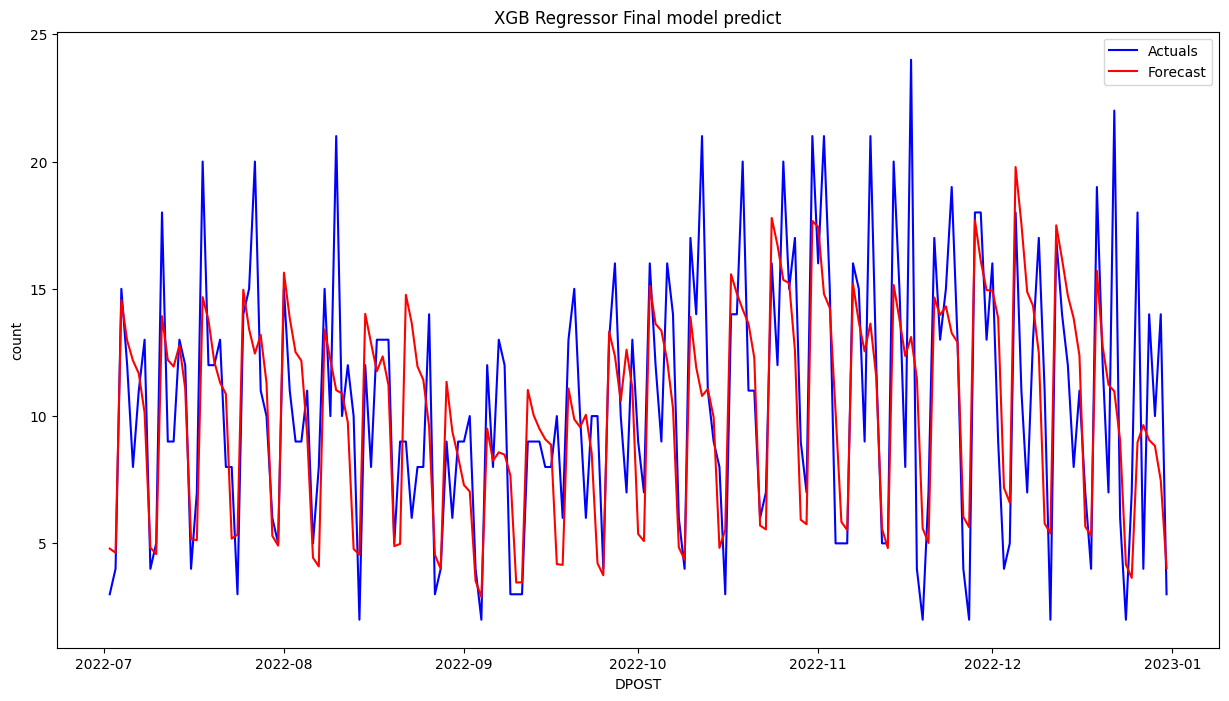

In [105]:
pred_df = pd.DataFrame(index = test_df.index)
pred_df['preds'] = xgbr_model.predict(test_df.drop('count', axis = 1))
pred_df['preds'] = tr.revers_transform(pred_df, target = 'preds')
show_results(pred_df['preds'], test_df['count'],
             title='XGB Regressor Final')

In [136]:
rfr_model = sklearn.ensemble.RandomForestRegressor(**{'n_estimators': 700,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 7,
 'bootstrap': False}, random_state = 5555)
rfr_model.fit(train_df.dropna().drop(['count'], axis = 1), train_df.dropna()['count'])

RandomForestRegressor(bootstrap=False, max_depth=7, max_features='sqrt',
                      min_samples_leaf=2, min_samples_split=10,
                      n_estimators=700, random_state=5555)

Metrics for RFR Regressor
MAE: 2.638
WAPE: 0.25


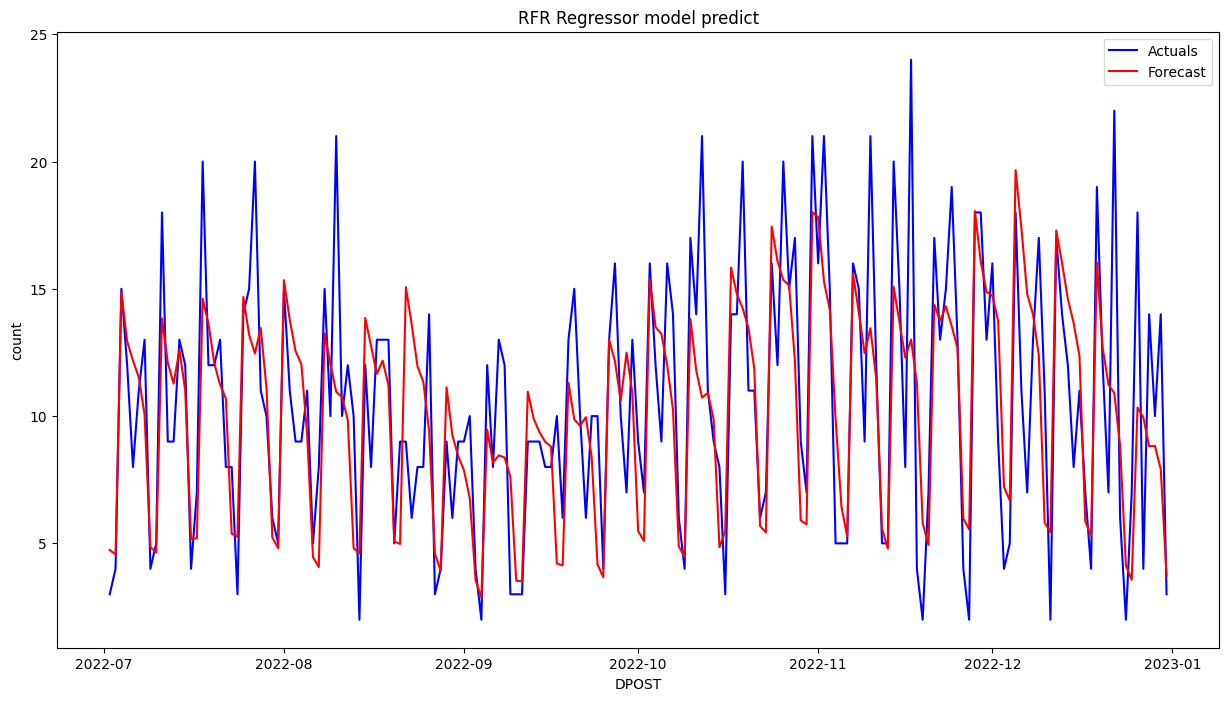

In [137]:
pred_df = pd.DataFrame(index = test_df.index)
pred_df['preds'] = rfr_model.predict(test_df.drop('count', axis = 1))
pred_df['preds'] = tr.revers_transform(pred_df, target = 'preds')
show_results(pred_df['preds'], test_df['count'],
             title='RFR Regressor')

Итак, есть победитель! И это Случайый лес, удалось улучшить значение отоносительно TrendRemover на 0,5 процента. И теперь WAPE составляет 25%.

## Прогноз недельного и месячного поступления

Итак, посмотрим как наша модель справляется с преддсказанием недельного и месячного поступления.

MAE: 6.32
WAPE: 0.089


Text(0.5, 1.0, 'Посупление по неделям, прогноз и реальныне значения')

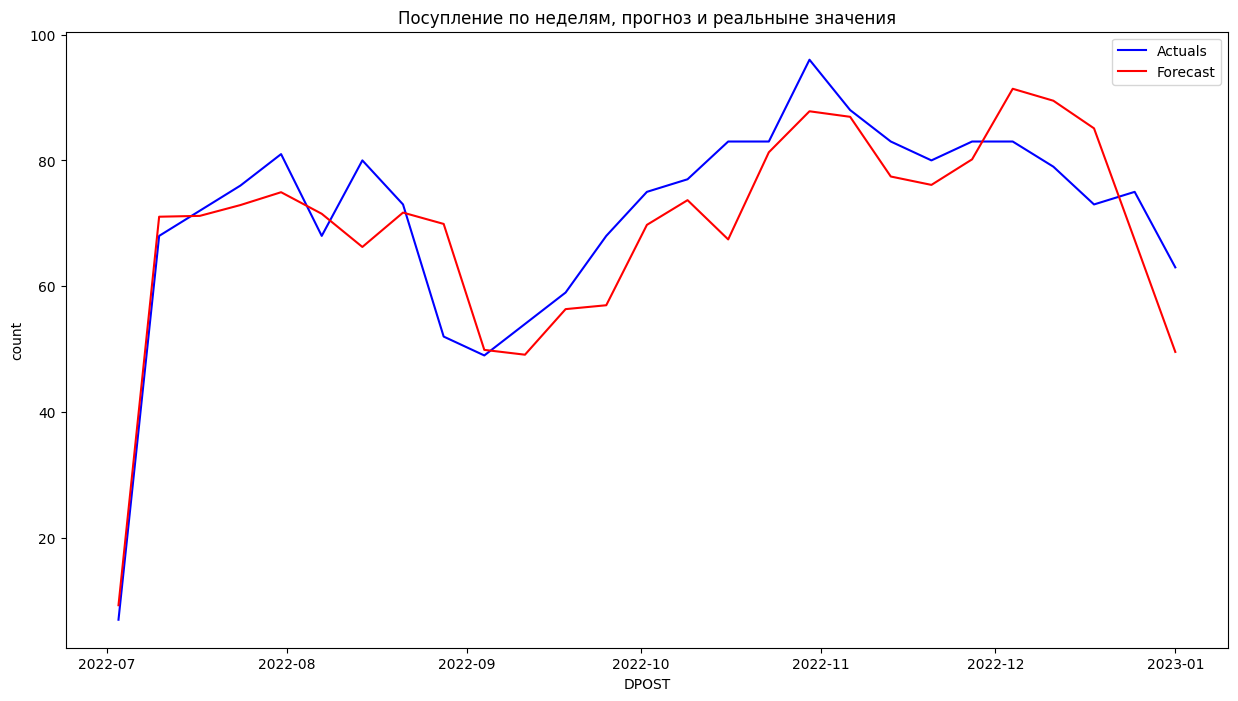

In [144]:
show_results(pred_df['preds'].resample('W').sum(), 
             test_df['count'].resample('W').sum()
            ) 
plt.title('Посупление по неделям, прогноз и реальныне значения')

MAE: 15.926
WAPE: 0.05


Text(0.5, 1.0, 'Посупление по неделям, прогноз и реальныне значения')

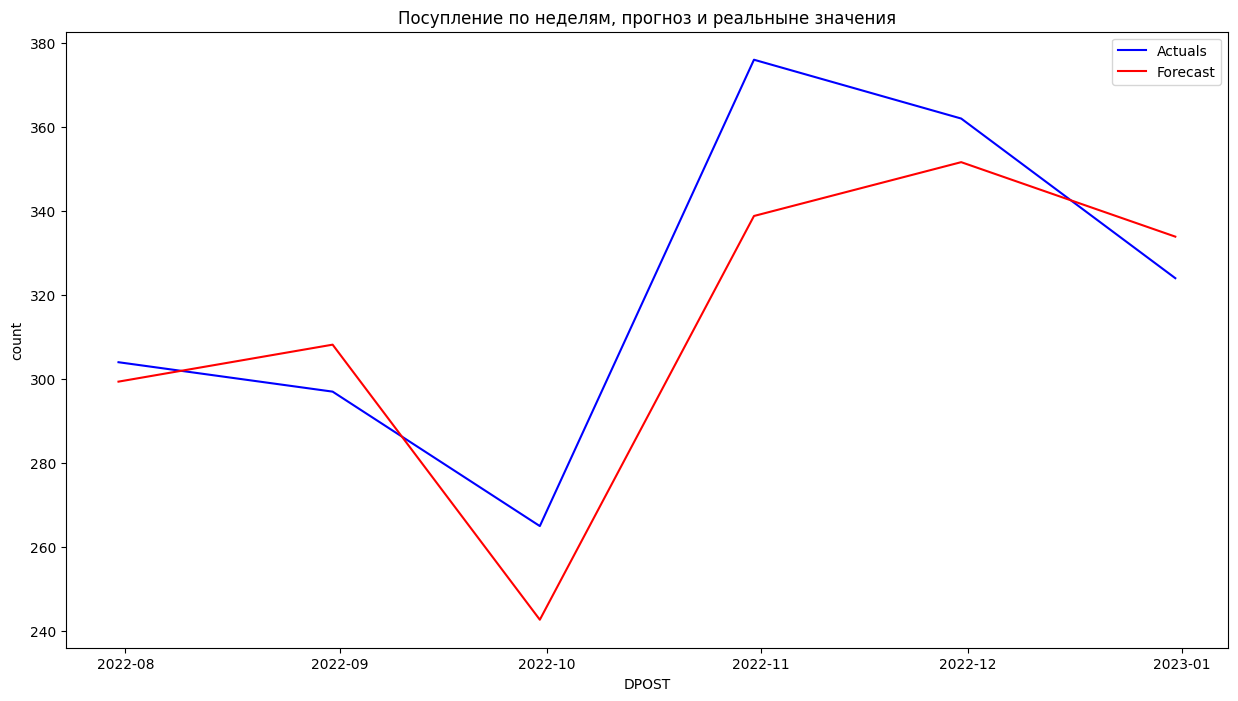

In [142]:
show_results(pred_df['preds'].resample('M').sum(), 
             test_df['count'].resample('M').sum(), 
            )
plt.title('Посупление по неделям, прогноз и реальныне значения')

Предсказания на аггрегированных данных оказались даже лучше, чем на прогнозе под дням, что говорит о том, что модель нелохо уловила среднюю тендению, а большая часть ошибки в дневном прогнозе приходится на случайные колебания.
Итого: Ошибка при недельном прогнозе - 9%, а при месячном - 5%.

## Сохранение модели

In [156]:
import pickle

to_save = {
    'model': rfr_model,
    'trend_remover': tr
}

with open('model.pkl', 'wb') as pkl_file:
    pickle.dump(to_save, pkl_file)

In [157]:
with open('model.pkl', 'rb') as pkl_file:
    loaded = pickle.load(pkl_file)
loaded

{'model': RandomForestRegressor(bootstrap=False, max_depth=7, max_features='sqrt',
                       min_samples_leaf=2, min_samples_split=10,
                       n_estimators=700, random_state=5555),
 'trend_remover': <__main__.TrendRemover at 0x7f62205984c0>}

Модель сохранена и загружена успешно!